In [1]:

from datetime import timedelta
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot
#from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from fbprophet import Prophet

#from statsmodels.compat.numpy import NP_LT_123

2022-08-31 18:27:54.427223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 18:27:54.427255: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datos Tasa de Incidencia Covid

In [2]:
basepath = "/media/jonathan/JHON/Tesis/DatosTesis/Data_Covid19/covid19FEB_JUL.csv"
data = pd.read_csv(basepath, sep=';',dtype={"municipio_distrito": str,
                                        "tasa_incidencia_acumulada_ultimos_14dias": str,
                                        "tasa_incidencia_acumulada_total": str},parse_dates=['fecha_informe'],usecols=[0,1,3], encoding='latin-1')

data['TasaIncidenciaAcumulada_Ultimos14dias'] = [int(value.split(",",1)[0]) for value in data['tasa_incidencia_acumulada_ultimos_14dias']]
data['fecha_informe'] = data['fecha_informe'].apply(lambda x:x.replace(hour=0,minute=0))
data.set_index('fecha_informe', inplace = True)



basepath = "/media/jonathan/JHON/Tesis/DatosTesis/Data_Covid19/covid19JUL_2022.csv"
data2 = pd.read_csv(basepath, sep=';',dtype={"municipio_distrito": str,
                                        "tasa_incidencia_acumulada_ultimos_14dias": str,
                                        "tasa_incidencia_acumulada_total": str},parse_dates=['fecha_informe'],usecols=[0,1,5], encoding='latin-1')

data2['TasaIncidenciaAcumulada_Ultimos14dias'] = [int(value.split(",",1)[0]) for value in data2['tasa_incidencia_acumulada_ultimos_14dias']]
data2['fecha_informe'] = data2['fecha_informe'].apply(lambda x:x.replace(hour=0,minute=0))
data2.set_index('fecha_informe', inplace = True)

data2.head(2)

,municipio_distrito,tasa_incidencia_acumulada_ultimos_14dias,TasaIncidenciaAcumulada_Ultimos14dias
fecha_informe,,,
2022-03-29,Madrid-Retiro,"301,6",301
2022-03-29,Madrid-Salamanca,"266,5",266


# Tablas Tasa de Incidencia Covid

In [3]:
table = pd.pivot_table(data, values=["TasaIncidenciaAcumulada_Ultimos14dias"], index=["fecha_informe"], columns=["municipio_distrito"], aggfunc={"TasaIncidenciaAcumulada_Ultimos14dias":"first"})
table.head(5)

table2 = pd.pivot_table(data2, values=["TasaIncidenciaAcumulada_Ultimos14dias"], index=["fecha_informe"], columns=["municipio_distrito"], aggfunc={"TasaIncidenciaAcumulada_Ultimos14dias":"first"})
table2.head(5)

table = table.astype(np.float64)
table2 = table2.astype(np.float64)

#Quitamos los niveles sobrantes del nivel superior y reiniciamos index - Solo se hace una vez de lo contrario genera problema
table.columns =[str(s2) for (s1,s2) in table.columns.tolist()]
table_Final = table.reset_index()
table_Final.set_index('fecha_informe', inplace = True)

table2.columns =[str(s2) for (s1,s2) in table2.columns.tolist()]
table2_Final = table2.reset_index()
table2_Final.set_index('fecha_informe', inplace = True)

#table.dtypes
#table.iloc[120:127,97:115]
table_Final.head(2)

,Ajalvir,Alameda del Valle,Alcalá de Henares,Alcobendas,Alcorcón,Aldea del Fresno,Algete,Alpedrete,Ambite,Anchuelo,...,Villamanta,Villamantilla,Villanueva de Perales,Villanueva de la Cañada,Villanueva del Pardillo,Villar del Olmo,Villarejo de Salvanés,Villaviciosa de Odón,Villavieja del Lozoya,Zarzalejo
fecha_informe,,,,,,,,,,,,,,,,,,,,,
2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Procesamiento datos desplazamiento por trayecto

In [4]:
def df_origen(origen,destino):     
    
    ######################PICKLE###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)

    df = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)    
    
    ######################PICKLE 1###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento1.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df1 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento1.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 2###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df2 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 3###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento3.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df3 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento3.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 4###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento4.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df4 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento4.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 5###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento5.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df5 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento5.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 6###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento6.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df6 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento6.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    #Filtramos el destino
    columns_names_df = df.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)    
    
    #Cambiamos el nombre de las columnas
    lines_names = {"19024":"Fuera_Madrid","2800601":"Fuera_Madrid","2806504":"Fuera_Madrid","2807901":"Centro","2807902":"Arganzuela","2807903":"Retiro","2807904":"Salamanca","2807905":"Chamartín","2807906":"Tetuán","2807907":"Chamberí","2807908":"El_Pardo","2807909":"Moncloa-Aravaca","2807910":"Latina","2807911":"Carabanchel","2807912":"Usera","2807913":"Puente_de_Vallecas","2807914":"Moratalaz","2807915":"Ciudad_Lineal","2807916":"Hortaleza","2807917":"Villaverde","2807918":"Villa_de_Vallecas","2807919":"Vicálvaro","2807920":"San Blas-Canillejas","2812301":"Fuera_Madrid","2807921":"Barajas"}            
    df_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df_Final['Fecha'] = df_Final.index.date
    df_Final['Año'] = df_Final.index.year                                
    df_Final['Mes'] = df_Final.index.month                               
    df_Final['ID_Dia'] = df_Final.index.dayofweek
    df_Final['Hora'] = df_Final.index.hour
    df_Final['WeekNo'] = df_Final.index.isocalendar().week
    df_Final[lines_names[origen]] = table_Final["Madrid"+"-"+lines_names[origen]].loc['2020-02-14':'2020-03-16']
    df_Final[lines_names[destino]] = table_Final["Madrid"+"-"+lines_names[destino]].loc['2020-02-14':'2020-03-16']
          
    
    #Filtramos el destino
    columns_names_df = df1.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df1_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento1.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df1_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df1_Final['Fecha'] = df1_Final.index.date
    df1_Final['Año'] = df1_Final.index.year                                
    df1_Final['Mes'] = df1_Final.index.month                               
    df1_Final['ID_Dia'] = df1_Final.index.dayofweek
    df1_Final['Hora'] = df1_Final.index.hour
    df1_Final['WeekNo'] = df1_Final.index.isocalendar().week
    df1_Final[lines_names[origen]] = table_Final["Madrid"+"-"+lines_names[origen]].loc['2020-03-17':'2020-05-31']    
    df1_Final[lines_names[destino]] = table_Final["Madrid"+"-"+lines_names[destino]].loc['2020-03-17':'2020-05-31']    

    #Filtramos el destino
    columns_names_df = df2.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df2_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df2_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df2_Final['Fecha'] = df2_Final.index.date
    df2_Final['Año'] = df2_Final.index.year                                
    df2_Final['Mes'] = df2_Final.index.month                               
    df2_Final['ID_Dia'] = df2_Final.index.dayofweek
    df2_Final['Hora'] = df2_Final.index.hour
    df2_Final['WeekNo'] = df2_Final.index.isocalendar().week   
    df2_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-06-01':'2020-07-31']
    df2_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-06-01':'2020-07-31']
    
    
    #Filtramos el destino
    columns_names_df = df3.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df3_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento3.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df3_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df3_Final['Fecha'] = df3_Final.index.date
    df3_Final['Año'] = df3_Final.index.year                                
    df3_Final['Mes'] = df3_Final.index.month                               
    df3_Final['ID_Dia'] = df3_Final.index.dayofweek
    df3_Final['Hora'] = df3_Final.index.hour
    df3_Final['WeekNo'] = df3_Final.index.isocalendar().week
    df3_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-08-01':'2020-10-31']
    df3_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-08-01':'2020-10-31']
    
    
    #Filtramos el destino
    columns_names_df = df4.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df4_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento4.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df4_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df4_Final['Fecha'] = df4_Final.index.date
    df4_Final['Año'] = df4_Final.index.year                                
    df4_Final['Mes'] = df4_Final.index.month                               
    df4_Final['ID_Dia'] = df4_Final.index.dayofweek
    df4_Final['Hora'] = df4_Final.index.hour
    df4_Final['WeekNo'] = df4_Final.index.isocalendar().week   
    df4_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-11-01':'2020-12-31']
    df4_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-11-01':'2020-12-31']
    
    
    #Filtramos el destino
    columns_names_df = df5.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df5_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento5.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)    
    
    #Cambiamos el nombre de las columnas    
    df5_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df5_Final['Fecha'] = df5_Final.index.date
    df5_Final['Año'] = df5_Final.index.year                                
    df5_Final['Mes'] = df5_Final.index.month                               
    df5_Final['ID_Dia'] = df5_Final.index.dayofweek
    df5_Final['Hora'] = df5_Final.index.hour
    df5_Final['WeekNo'] = df5_Final.index.isocalendar().week    
    df5_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2021-01-01':'2021-01-31']
    df5_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2021-01-01':'2021-01-31']
    

    #Filtramos el destino
    columns_names_df = df6.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df6_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento6.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)        
    
    #Cambiamos el nombre de las columnas    
    df6_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df6_Final['Fecha'] = df6_Final.index.date
    df6_Final['Año'] = df6_Final.index.year                                
    df6_Final['Mes'] = df6_Final.index.month                               
    df6_Final['ID_Dia'] = df6_Final.index.dayofweek
    df6_Final['Hora'] = df6_Final.index.hour
    df6_Final['WeekNo'] = df6_Final.index.isocalendar().week  
    df6_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2021-02-01':'2021-05-09']
    df6_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2021-02-01':'2021-05-09']
    
    
    return df_Final, df1_Final, df2_Final, df3_Final, df4_Final, df5_Final, df6_Final, listaDst

origen = "2807905"
destino = "2807901"
df_Final, df1_Final, df2_Final, df3_Final, df4_Final, df5_Final, df6_Final, listaDst = df_origen(origen,destino)
df_Final.tail(2)

,Chamartín_Centro,Fecha,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
ds,,,,,,,,,
2020-03-16 22:00:00,55.801,2020-03-16,2020,3,0,22,12,NaN,NaN
2020-03-16 23:00:00,21.306,2020-03-16,2020,3,0,23,12,NaN,NaN


In [5]:
#df6_Final[2040:2100]

In [6]:
#table2_Final.iloc[:50,88:200]
#table_Final.iloc[0:50,88:200]

In [7]:
#df_Final.iloc[288:348]

# Descubrimos las características de los datos

In [8]:
df_Final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2020-02-14 00:00:00 to 2020-03-16 23:00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Chamartín_Centro  768 non-null    float64
 1   Fecha             768 non-null    object 
 2   Año               768 non-null    int64  
 3   Mes               768 non-null    int64  
 4   ID_Dia            768 non-null    int64  
 5   Hora              768 non-null    int64  
 6   WeekNo            768 non-null    UInt32 
 7   Chamartín         20 non-null     float64
 8   Centro            20 non-null     float64
dtypes: UInt32(1), float64(3), int64(4), object(1)
memory usage: 57.8+ KB


In [9]:
df_Final.isnull().sum()

Chamartín_Centro      0
Fecha                 0
Año                   0
Mes                   0
ID_Dia                0
Hora                  0
WeekNo                0
Chamartín           748
Centro              748
dtype: int64

In [10]:
def completar_datos(dataframe1):
    ##################### Completar penúltima Columna ###############################
    Distrito=dataframe1.columns[7]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición     
            Inc = 0                        

        dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') #Rango de fechas 24 horas  
        
        #Reemplazamos cada celda que posea NaN por el valor capturado a las 0 Horas             
        for date2 in dates_range2[1:-1]:            
            dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date2),Distrito] = Inc    
        cont=cont+24

        if cont1 < len(dates_range)-2: 
            cont1=cont1+1
            cont2=cont2+1
    #último Rango de fecha faltante
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[1:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc

    ##################### Completar última Columna ###############################    
    Distrito=dataframe1.columns[8]
    cont=0
    cont1=0
    cont2=1
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final)
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]

        if np.isnan(Inc):        
            Inc = 0                        

        dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H')    
        for date2 in dates_range2[1:-1]:                
            dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date2),Distrito] = Inc    
        cont=cont+24

        if cont1 < len(dates_range)-2: 
            cont1=cont1+1
            cont2=cont2+1

    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[1:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc
    dataframe1 = dataframe1.fillna(0)
    
    return dataframe1

# El 9 de Junio ya es otro valor de Covid ¿Funciona el timestamp?

In [11]:
def completar_datos2(dataframe1):
    ##################### Completar penúltima Columna ###############################
    Distrito=dataframe1.columns[7]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    week=[1,2,3,4,5,6,7]
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición             
            cont=cont+24
            
            if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
        if np.isnan(Inc)!=True:            
            dates_range_week = []
            if cont+168 <= len(dataframe1.index):
                cont=cont+168            
            else:
                cont=cont+(len(dataframe1.index)-cont)                
                
            for dia in week:
                dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') 
                dates_range_week.extend(list(dates_range2[0:-1]))               
                
                if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
            for datew in dates_range_week:                
                dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==datew),Distrito] = Inc                                           
            
                
            if cont == len(dataframe1.index):
                break
                
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[0:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc       
            

    ##################### Completar última Columna ###############################    
    Distrito=dataframe1.columns[8]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    week=[1,2,3,4,5,6,7]
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición             
            cont=cont+24
            
            if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
        if np.isnan(Inc)!=True:            
            dates_range_week = []
            if cont+168 <= len(dataframe1.index):
                cont=cont+168            
            else:
                cont=cont+(len(dataframe1.index)-cont)                
                
            for dia in week:
                dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') 
                dates_range_week.extend(list(dates_range2[0:-1]))               
                
                if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
            for datew in dates_range_week:                
                dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==datew),Distrito] = Inc                                           
            
                
            if cont == len(dataframe1.index):
                break
                
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[0:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc   
    dataframe1 = dataframe1.fillna(0)
    
    return dataframe1

In [12]:
df_Final = completar_datos(df_Final)
df1_Final = completar_datos(df1_Final)
df2_Final = completar_datos2(df2_Final)
df3_Final = completar_datos2(df3_Final)
df4_Final = completar_datos2(df4_Final)
df5_Final = completar_datos2(df5_Final)
df6_Final = completar_datos2(df6_Final)

In [13]:
df6_Final.iloc[:-500]
#df_Final.iloc[500:-20]

,Chamartín_Centro,Fecha,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
ds,,,,,,,,,
2021-02-01 00:00:00,33.911,2021-02-01,2021,2,0,0,5,0.0,0.0
2021-02-01 01:00:00,15.247,2021-02-01,2021,2,0,1,5,0.0,0.0
2021-02-01 02:00:00,57.649,2021-02-01,2021,2,0,2,5,0.0,0.0
2021-02-01 03:00:00,26.618,2021-02-01,2021,2,0,3,5,0.0,0.0
2021-02-01 04:00:00,85.337,2021-02-01,2021,2,0,4,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-04-18 23:00:00,91.617,2021-04-18,2021,4,6,23,15,359.0,437.0
2021-04-19 00:00:00,73.590,2021-04-19,2021,4,0,0,16,359.0,437.0
2021-04-19 01:00:00,59.955,2021-04-19,2021,4,0,1,16,359.0,437.0


# Comprobamos nuevamente si existen datos incompletos

In [14]:
print(df_Final.isnull().sum())
print(df1_Final.isnull().sum())
print(df2_Final.isnull().sum())
print(df3_Final.isnull().sum())
print(df4_Final.isnull().sum())
print(df5_Final.isnull().sum())
print(df6_Final.isnull().sum())

Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Ch

In [15]:
df_Final.describe()

,Chamartín_Centro,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
count,768.000000,768.0,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,740.921574,2020.0,2.500000,3.093750,11.500000,9.343750,13.375000,9.750000
std,576.350622,0.0,0.500326,2.053156,6.926698,1.361249,24.496494,17.931639
min,0.000000,2020.0,2.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,197.958000,2020.0,2.000000,1.000000,5.750000,8.000000,0.000000,0.000000
50%,684.695000,2020.0,2.500000,3.000000,11.500000,9.000000,0.000000,0.000000
75%,1178.244500,2020.0,3.000000,5.000000,17.250000,10.250000,12.250000,9.500000
max,2387.116000,2020.0,3.000000,6.000000,23.000000,12.000000,86.000000,64.000000


In [16]:
df_Final.describe(include=['O'])

,Fecha
count,768
unique,32
top,2020-02-14
freq,24


<AxesSubplot:>

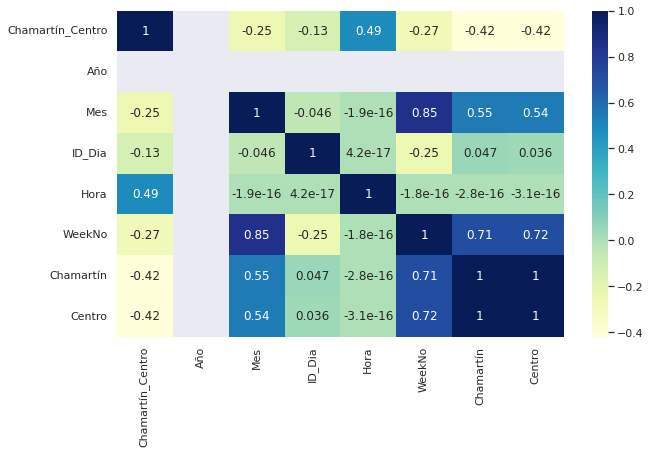

In [17]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(df_Final.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

In [18]:
df_Final.drop(columns=["Fecha","Año","Mes","WeekNo"])

,Chamartín_Centro,ID_Dia,Hora,Chamartín,Centro
ds,,,,,
2020-02-14 00:00:00,308.104,4,0,0.0,0.0
2020-02-14 01:00:00,165.496,4,1,0.0,0.0
2020-02-14 02:00:00,179.838,4,2,0.0,0.0
2020-02-14 03:00:00,130.675,4,3,0.0,0.0
2020-02-14 04:00:00,123.672,4,4,0.0,0.0
...,...,...,...,...,...
2020-03-16 19:00:00,112.833,0,19,86.0,64.0
2020-03-16 20:00:00,158.164,0,20,86.0,64.0
2020-03-16 21:00:00,71.365,0,21,86.0,64.0


## Correlación de desplazamientos con los datos Covid

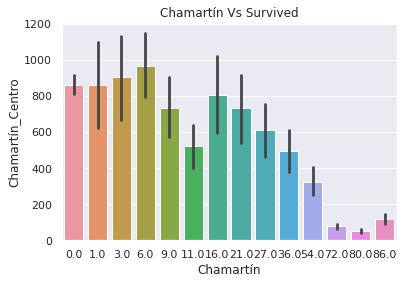

,Chamartín,Chamartín_Centro
3,6.000000,968.061583
2,3.000000,903.742042
0,0.000000,863.353081
1,1.000000,858.953042
6,16.000000,806.206792
7,21.000000,733.127792
4,9.000000,731.142333
8,27.000000,611.871500
5,11.000000,521.269625
9,36.000000,494.652333


In [19]:
def survived_bar_plot(feature):
    plt.figure(figsize = (6,4))
    sns.barplot(data = df_Final , x = feature , y = "Chamartín_Centro").set_title(f"{feature} Vs Survived")
    plt.show()
def survived_table(feature):
    return df_Final[[feature, "Chamartín_Centro"]].groupby([feature], as_index=False).mean().sort_values(by='Chamartín_Centro', ascending=False).style.background_gradient(low=0.75,high=1)
def survived_hist_plot(feature):
    plt.figure(figsize = (6,4))
    sns.histplot(data = df_Final , x = feature , hue = "Chamartín_Centro",binwidth=5 ,multiple = "stack" ).set_title(f"{feature} Vs Survived")
    plt.show()
    
survived_bar_plot('Chamartín')
survived_table("Chamartín")

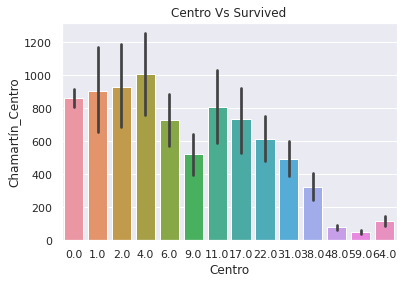

,Centro,Chamartín_Centro
3,4.000000,1008.112583
2,2.000000,928.010583
1,1.000000,903.742042
0,0.000000,863.121500
6,11.000000,806.206792
7,17.000000,733.127792
4,6.000000,731.142333
8,22.000000,611.871500
5,9.000000,521.269625
9,31.000000,494.652333


In [20]:
survived_bar_plot('Centro')
survived_table("Centro")

## Correlación del día con el número de desplazamientos

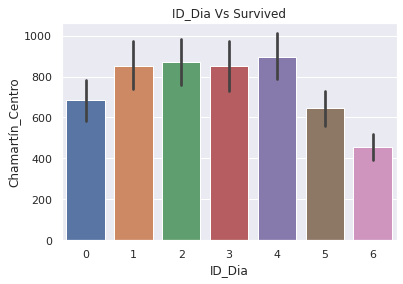

,ID_Dia,Chamartín_Centro
4,4,896.882692
2,2,868.607219
1,1,853.392469
3,3,849.681687
0,0,685.709342
5,5,645.902608
6,6,456.058333


In [21]:
survived_bar_plot('ID_Dia')
survived_table("ID_Dia")

## Correlación de la Hora con el número de esplazamientos

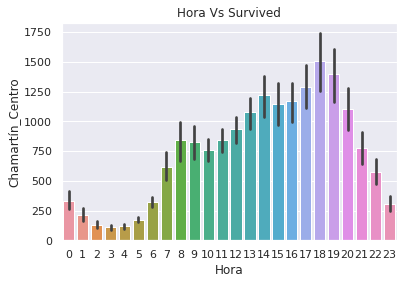

,Hora,Chamartín_Centro
18,18,1504.077875
19,19,1395.706062
17,17,1288.724125
14,14,1220.141406
16,16,1168.317594
15,15,1141.875594
20,20,1099.375844
13,13,1080.181156
12,12,934.631313
11,11,845.799719


In [22]:
survived_bar_plot('Hora')
survived_table("Hora")

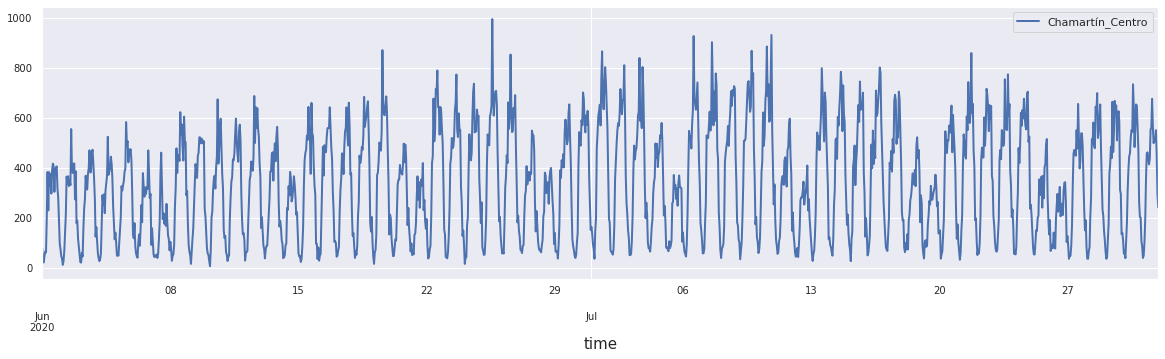

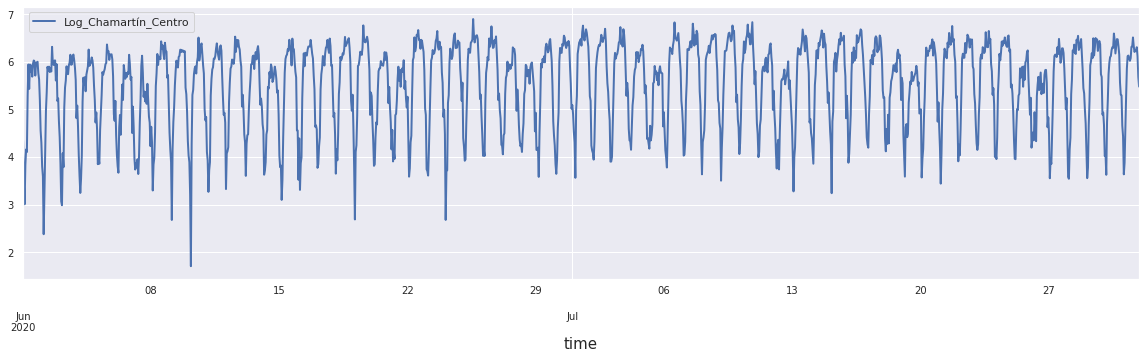

In [23]:
df2_Final['Log_Chamartín_Centro']=np.log(df2_Final['Chamartín_Centro'])
df2_Final.head()

df2_Final[['Chamartín_Centro']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);
df2_Final[['Log_Chamartín_Centro']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

# Estacionalidad
## Al observar la estacionalidad se observa que la serie tiene un marcado componente estacional, que consiste en un aumento de los desplazamientos cada 24 horas. 

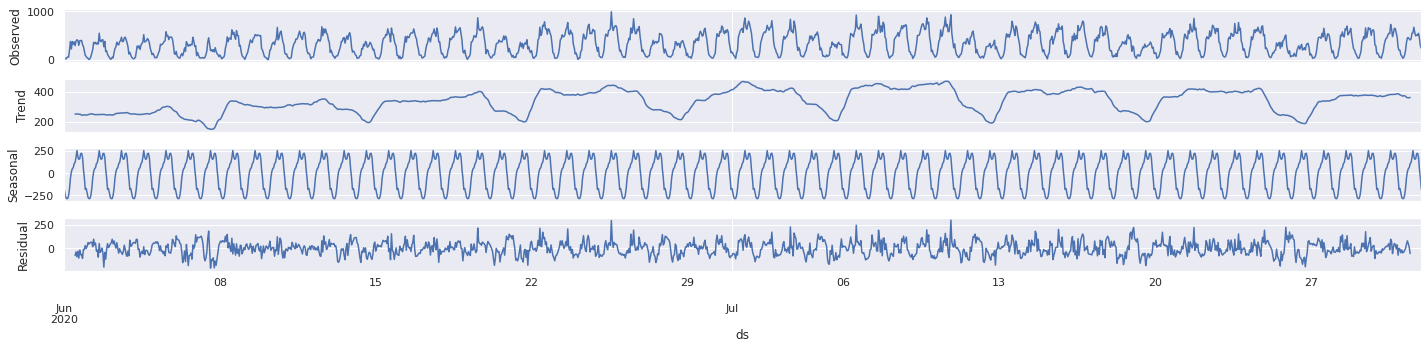

In [24]:
res = seasonal_decompose(df2_Final['Chamartín_Centro'], model='additive',period=24)

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

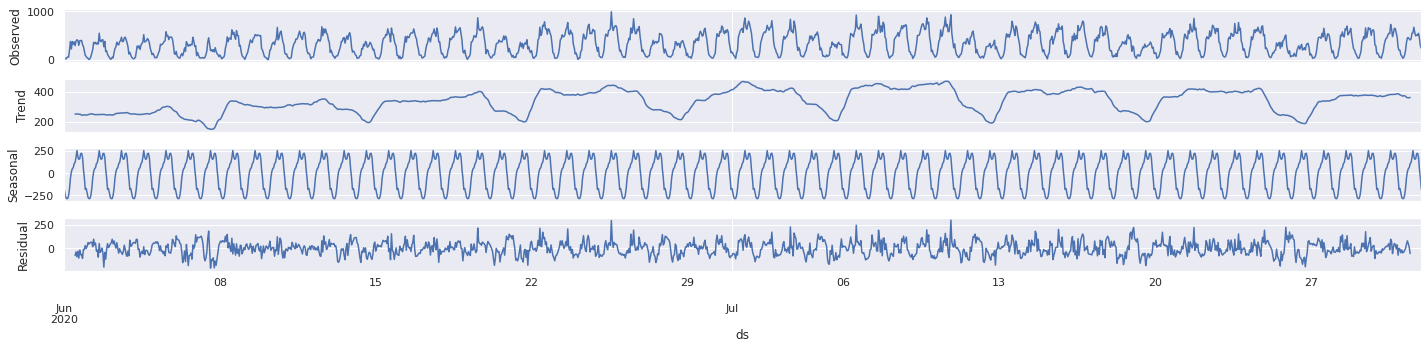

In [25]:
res = seasonal_decompose(df2_Final["Chamartín_Centro"], model='additive',period=24)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

# Análisis de la Estacionariedad 
## Se desea una serie estacionaria 
##   Cuando la serie no es estacionaria en varianza se requiere una transformación logarítmica

In [26]:
desplazamientos=df2_Final['Chamartín_Centro']
Log_desplazamientos=df2_Final['Log_Chamartín_Centro']

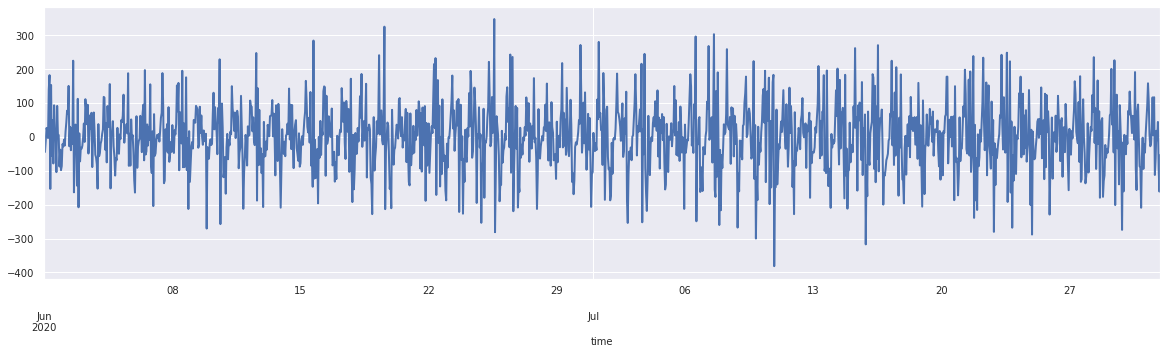

In [27]:
#Primera diferencia de la serie (niveles)
desplazamientos.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=10);

## Al aplicar la transformacíon logaritmica se está eliminando la tendencia, por lo que el analisis de la serie se realizará con la serie en logaritmo.

<AxesSubplot:xlabel='ds'>

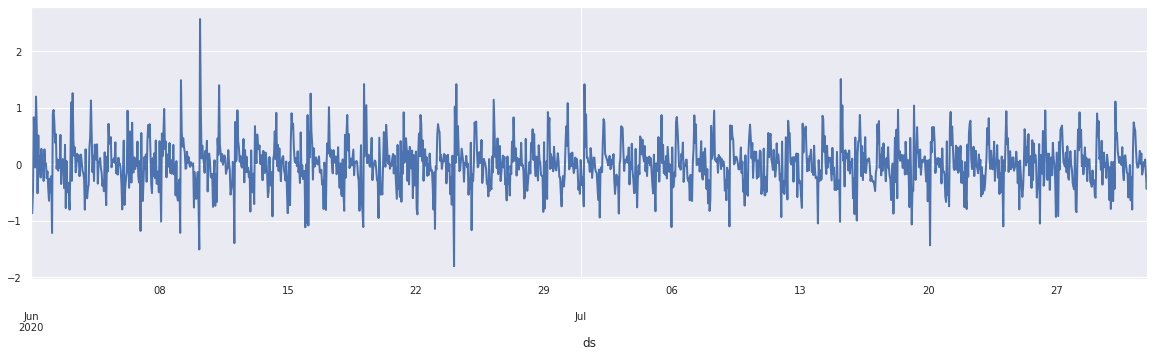

In [28]:
#Primera diferencia de la serie (logaritmo)
Log_desplazamientos.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)

## Prueba de Dickey- Fuller para realizar una verificación formal de la estacionariedad de la serie.

### Los resultados de la prueba de Dickey- Fuller confirman que, con un nivel de significancia del 1%, la serie de desplazamientos no es estacionaria.
### Todo OK

In [29]:
result = adfuller(df2_Final['Log_Chamartín_Centro'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.167333
p-value: 0.021955
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


# Wrangling The Data (Manipulación de Datos)

# Modelo Prophet

In [30]:
data_pf = pd.DataFrame({'ds': df2_Final.Log_Chamartín_Centro.index[:], 'y': df2_Final.Log_Chamartín_Centro})
data_pf.head()

,ds,y
ds,,
2020-06-01 00:00:00,2020-06-01 00:00:00,4.345453
2020-06-01 01:00:00,2020-06-01 01:00:00,3.478621
2020-06-01 02:00:00,2020-06-01 02:00:00,3.005138
2020-06-01 03:00:00,2020-06-01 03:00:00,3.836890
2020-06-01 04:00:00,2020-06-01 04:00:00,4.159836


In [31]:
X = data_pf.y
Y = data_pf.ds
size = int(len(X) * 0.9)
train_X, test_X = X[0:size], X[size:len(X)]
train_Y, test_Y = Y[0:size], Y[size:len(Y)]
    
Train = pd.concat([train_Y,train_X], axis=1)
Test = pd.concat([test_Y,test_X], axis=1)

## Realizamos entrenamiento con Prophet

In [32]:
predictions = list()
    
def rolling_forecast():   
    history = Train.copy()
    
    for t in range(len(test_X)):
        m = Prophet()
        m.fit(history);
        future = m.make_future_dataframe(periods=1, freq='MS')
        forecast = m.predict(future)
        output=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        yhat = output[['yhat']][len(history):].values[0][0]
        predictions.append(yhat)
        obs = pd.DataFrame(Test[['ds','y']].iloc[t])
        history = pd.concat([history, obs.transpose()],axis=0)
        print('predicted=%f, expected=%f' % (yhat, obs.transpose()['y']))

    
    error_PROPHET = mean_squared_error(test_X, predictions)**0.5
    print('Test RMSE: %.3f' % error_PROPHET)
    
rolling_forecast()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.7384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3346.45   0.000740533       119.917      0.5477           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       3346.61   4.25259e-05       62.2279   5.855e-07       0.001      233  LS failed, Hessian reset 
     199       3346.61   5.41348e-07       46.8498           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       3346.62   8.83241e-06       47.6885   1.306e-07       0.001      494  LS failed, Hessian reset 
     289       3346.62   3.47957e-08       60.5843      0.1054      0.1054      514   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.905246, expected=6.242900


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.7328
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3347.83     0.0014425       74.7137      0.9033      0.9033      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3347.85   0.000147871       129.418   1.419e-06       0.001      165  LS failed, Hessian reset 
     152       3347.96   1.54004e-05       61.7844   2.659e-07       0.001      272  LS failed, Hessian reset 
     189       3347.96   1.12698e-07       49.4979      0.1496      0.3282      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.609968, expected=5.653145


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -17.2829
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3350.3   9.61212e-05       42.7498       1.362      0.1362      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        3350.3   3.14016e-05       61.8959    6.25e-07       0.001      198  LS failed, Hessian reset 
     132       3350.31    1.2634e-05       51.7808    1.93e-07       0.001      266  LS failed, Hessian reset 
     144       3350.31   2.45022e-07       50.9251      0.1481           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
predicted=5.272568, expected=5.271244


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.0037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3352.88   1.85364e-05       56.3722      0.4892      0.4892      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3352.91   8.19695e-05       101.335   1.068e-06       0.001      206  LS failed, Hessian reset 
     170       3352.94   3.14282e-07       55.5314      0.2869      0.2869      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.943629, expected=4.889364


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -24.0701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3355.54   0.000574496       83.2418           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       3355.61   0.000157843       126.684   2.075e-06       0.001      194  LS failed, Hessian reset 
     184       3355.74   1.66416e-05       58.1602   3.044e-07       0.001      341  LS failed, Hessian reset 
     199       3355.74   4.02884e-07       48.3332           1           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.057237, expected=5.246166


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.2429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3354.15   0.000763994       53.0608      0.4295           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3354.16   4.28808e-05       55.6285   6.403e-07       0.001      189  LS failed, Hessian reset 
     193       3354.21   0.000165047       41.9288    3.47e-06       0.001      337  LS failed, Hessian reset 
     199       3354.21   4.18112e-05       49.0577      0.3774           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3354.22   2.20945e-06       57.3318   3.813e-08       0.001      418  LS failed, Hessian reset 
     233       3354.22   1.93556e-07       51.2054      0.6168      0.6168      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.684536, expected=4.196465


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -34.8846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3355.39    0.00191903       253.344       4.525      0.4525      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3355.92   0.000494646       220.018   3.329e-06       0.001      197  LS failed, Hessian reset 
     172       3356.41   9.45596e-05       86.0463   1.228e-06       0.001      326  LS failed, Hessian reset 
     199       3356.68   0.000204811       74.7973      0.8977      0.8977      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3356.79    0.00013739       133.677   1.627e-06       0.001      421  LS failed, Hessian reset 
     299        3356.9   1.30998e-06       57.4955           1           1      531   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.287374, expected=4.356606


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -31.9941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98        3356.7   0.000201697       165.849   1.809e-06       0.001      163  LS failed, Hessian reset 
      99       3356.71   0.000179061       151.641           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        3357.3    0.00146214       70.2011   1.943e-05       0.001      293  LS failed, Hessian reset 
     199       3357.43   1.63063e-05        66.337      0.3675           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       3357.45   5.31164e-05       69.7706   6.058e-07       0.001      496  LS failed, Hessian reset 
     299       3357.46   1.61154e-07       58.4261      0.1114      0.1114      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.041644, expected=4.518239


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.3216
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       3355.15   0.000334106       157.909   4.419e-06       0.001       91  LS failed, Hessian reset 
      55       3355.76   0.000115761       105.613   9.456e-07       0.001      160  LS failed, Hessian reset 
      99        3356.8   0.000123562       100.664      0.3648      0.3648      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       3357.34   1.47958e-05       50.8765    3.13e-07       0.001      387  LS failed, Hessian reset 
     199       3357.34   4.68789e-06       48.9343           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       3357.34   1.53087e-06       46.0016   2.603e-08       0.001      468  LS failed, Hessian reset 
     229       3357.34   6.63156e-08       62.0172     0.04712   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.104290, expected=4.352263


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -32.0698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3358.94   0.000598183       101.873      0.7006      0.7006      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       3359.93   0.000181699       167.741   1.516e-06       0.001      267  LS failed, Hessian reset 
     199       3360.06   0.000176924       101.183      0.5293      0.5293      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221        3360.1   6.96872e-06       54.5514   1.315e-07       0.001      367  LS failed, Hessian reset 
     242        3360.1   4.24321e-06       58.0148   6.584e-08       0.001      435  LS failed, Hessian reset 
     250        3360.1   2.33921e-07       54.7983      0.2229           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.494062, expected=4.941435


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -23.4853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       3362.14   0.000414619       188.855   6.756e-06       0.001      120  LS failed, Hessian reset 
      99       3362.49    0.00107742        122.86        0.73        0.73      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        3362.7   4.61315e-05       61.2428   7.628e-07       0.001      277  LS failed, Hessian reset 
     169       3362.71   9.96319e-08       52.6103      0.1073           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.064975, expected=4.560361


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -28.6743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3363.55   0.000297602       61.4396           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3364.07   1.26184e-06         44.41      0.0473           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3364.07   4.25174e-07       55.6279      0.0598           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.552136, expected=4.333768


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -32.3955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3360.59   0.000887483       139.543      0.3175      0.3175      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       3361.29   9.89943e-05       89.5974   7.378e-07       0.001      273  LS failed, Hessian reset 
     199        3361.4   0.000258137       51.4712           1           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       3361.44   1.12253e-05       65.1532   2.008e-07       0.001      436  LS failed, Hessian reset 
     284       3361.44   7.81278e-08       40.3445      0.3766           1      484   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.807745, expected=5.283716
Initial log joint probability = -20.01
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       3363.93   9.24042e-05       81.2774   6.043e-07       0.001      157  LS failed, Hessian reset 
      99       3363.98   7.46096e-05       54.7826       1.082      0.1082      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3363.99    2.8128e-09       61.6318    0.005569      0.1187      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.874621, expected=5.521469


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.2279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       3366.95   6.97355e-05       70.6894   7.292e-07       0.001      141  LS failed, Hessian reset 
      90       3366.97   9.21565e-05       63.7031   1.467e-06       0.001      216  LS failed, Hessian reset 
      99       3366.98   5.32888e-07       47.0688      0.1725      0.1725      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3366.98   1.09891e-07       50.4424        0.31           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.888502, expected=5.686256


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       3369.98   0.000195712       115.101   3.019e-06       0.001      136  LS failed, Hessian reset 
      99       3369.99   5.43952e-06       51.7024      0.5195      0.5195      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3370.11   8.38304e-06       59.3219   1.672e-07       0.001      281  LS failed, Hessian reset 
     199       3370.12   2.33569e-05       66.1236       0.593       0.593      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       3370.14   1.78709e-06       63.0078    2.71e-08       0.001      478  LS failed, Hessian reset 
     293       3370.14   2.63019e-07       52.9568      0.2843           1      508   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.971703, expected=5.408749


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       3372.19   0.000100837       61.4742   1.988e-06       0.001      150  LS failed, Hessian reset 
      99       3372.23   9.34504e-06       42.3559      0.4174      0.4174      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3372.24   0.000166924       75.1242     2.6e-06       0.001      249  LS failed, Hessian reset 
     167       3372.25   2.47713e-06       49.4669   3.805e-08       0.001      349  LS failed, Hessian reset 
     191       3372.25   1.77419e-06       60.0423    3.02e-08       0.001      415  LS failed, Hessian reset 
     194       3372.25   2.13873e-07       41.5072      0.4986      0.4986      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.102740, expected=5.589467


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.8298
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       3374.64   0.000261116        110.73   2.991e-06       0.001      153  LS failed, Hessian reset 
      99       3374.64   7.26673e-06       64.1944      0.2046           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       3374.74   6.99876e-05       60.8489   9.021e-07       0.001      292  LS failed, Hessian reset 
     199       3374.75   0.000460871       83.9141           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       3374.77   8.43815e-06       60.2264   1.387e-07       0.001      443  LS failed, Hessian reset 
     267       3374.77   1.81098e-07       68.5351     0.06587      0.4036      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.186267, expected=5.776683


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.913
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       3377.57   9.82258e-05       95.2628   1.126e-06       0.001      145  LS failed, Hessian reset 
      99       3377.59   0.000158442       90.1933           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3377.65   7.51974e-05       65.2609   1.101e-06       0.001      284  LS failed, Hessian reset 
     170       3377.68   1.54295e-08       43.8478     0.01542           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.162755, expected=5.323161


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.7182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3379.22   0.000350026       68.0415           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        3379.3   3.87464e-06       50.3448   5.795e-08       0.001      260  LS failed, Hessian reset 
     169        3379.3   1.24334e-07       63.6851      0.2335           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.058016, expected=5.422533


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3381.49   0.000665524       62.4882           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3381.49   9.92331e-05       84.8047   1.464e-06       0.001      177  LS failed, Hessian reset 
     199       3381.56   4.25195e-05       53.0706       0.878       0.878      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       3381.59   0.000101334        58.117   1.369e-06       0.001      470  LS failed, Hessian reset 
     299       3381.59   8.35778e-06       54.2628      0.6049      0.6049      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       3381.61   3.07588e-06        56.529   5.466e-08       0.001      583  LS failed, Hessian rese

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.988839, expected=5.542255
Initial log joint probability = -18.1374


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       3383.85   0.000135456       97.1085    1.83e-06       0.001      141  LS failed, Hessian reset 
      99       3383.87   2.87195e-06       56.8164           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       3383.88   9.28997e-05       125.418   9.434e-07       0.001      239  LS failed, Hessian reset 
     139       3383.89   3.44708e-07       56.5653           1           1      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.022252, expected=5.347055


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.5413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       3384.76   9.63355e-05       75.5027   6.756e-07       0.001      138  LS failed, Hessian reset 
      99       3384.81   8.63614e-05       59.4393      0.8568      0.8568      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3384.82   9.28648e-05       70.7299   1.125e-06       0.001      201  LS failed, Hessian reset 
     164       3384.93   9.94966e-05        109.21   1.284e-06       0.001      320  LS failed, Hessian reset 
     199       3384.94    2.7682e-06       61.6215      0.1663      0.9809      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3384.94   9.98444e-08       54.3919      0.3395      0.3395      404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.092319, expected=5.726356


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.1568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3387.49   0.000138696       48.0627       0.345           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       3387.53   0.000269627       170.759   2.502e-06       0.001      221  LS failed, Hessian reset 
     174       3387.55   1.69713e-05       72.5451   2.967e-07       0.001      346  LS failed, Hessian reset 
     193       3387.55   1.78887e-07       53.0451      0.2505           1      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.084319, expected=5.827863


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.7494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3390.5   3.01484e-05       54.0486           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3390.54    0.00011573       97.2499   1.947e-06       0.001      189  LS failed, Hessian reset 
     143       3390.56   3.33312e-06       38.6286   5.629e-08       0.001      270  LS failed, Hessian reset 
     149       3390.56   5.69007e-08       36.5825      0.1518      0.5177      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.917222, expected=5.833506


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.7333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       3393.37   0.000113652       122.355   1.394e-06       0.001      159  LS failed, Hessian reset 
      99       3393.39    2.2429e-05       56.5843      0.8874      0.8874      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3393.43   7.98342e-05       83.0133   1.158e-06       0.001      290  LS failed, Hessian reset 
     199       3393.45   2.61461e-05       72.9848           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       3393.48   7.43456e-05       61.4966   9.916e-07       0.001      485  LS failed, Hessian reset 
     293       3393.51   7.16463e-06       62.2972   1.403e-07       0.001      602  LS failed, Hessian reset 
     299       3393.51   2.85118e-06       53.0291       1.867   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.615757, expected=5.558865


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.0648
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       3396.03   8.38218e-05       69.7204   1.195e-06       0.001      141  LS failed, Hessian reset 
      99        3396.1   0.000184054       57.4153           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       3396.19   9.75573e-05        85.386   1.447e-06       0.001      274  LS failed, Hessian reset 
     199       3396.22   1.98419e-06       45.5135           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       3396.27   8.10155e-05       52.1043   1.101e-06       0.001      463  LS failed, Hessian reset 
     299       3396.31   1.10569e-05       77.0745           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.274022, expected=4.626765


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3398.09   0.000469632       94.5262     0.09599      0.2812      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       3398.46   0.000318826       197.438   3.607e-06       0.001      231  LS failed, Hessian reset 
     189       3398.57   0.000138294       134.154   1.377e-06       0.001      322  LS failed, Hessian reset 
     199       3398.57    1.0428e-05       42.9129           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3398.58     1.252e-07        61.259      0.2905      0.2905      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.933657, expected=4.833508


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -24.9883
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3401.35    0.00477625       72.5448      0.1222           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       3401.39   7.89623e-05       73.1937   7.521e-07       0.001      180  LS failed, Hessian reset 
     156       3401.53   5.07294e-05       47.3062   6.044e-07       0.001      289  LS failed, Hessian reset 
     181       3401.53   1.69405e-07       53.7855      0.3609      0.3609      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.044309, expected=4.470598


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -30.3001
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3403.96    0.00055498       98.9997      0.3163      0.8142      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3404.59   0.000272108        75.741      0.9183      0.9183      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       3404.62   4.86313e-06       63.7211   8.939e-08       0.001      347  LS failed, Hessian reset 
     234       3404.62   5.42574e-07       43.7638     0.05798      0.8463      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.662845, expected=3.553260


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -49.229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3404.2     0.0019822        84.722       4.834      0.4834      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195        3406.3    0.00163651       222.469   1.423e-05       0.001      304  LS failed, Hessian reset 
     199       3406.44    0.00189155       112.742           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       3406.69   2.53538e-05       58.7308   2.807e-07       0.001      497  LS failed, Hessian reset 
     299       3406.69   1.90807e-06       54.4814      0.5775      0.5775      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       3406.69   3.20437e-07       64.1586      0.1721           1      521   
Optimization terminate

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.260705, expected=3.947062


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -40.1293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        3407.2   0.000158801       136.922   1.396e-06       0.001      119  LS failed, Hessian reset 
      99       3407.92    0.00576704       121.373      0.2597           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3409.48   0.000940494       351.073   1.018e-05       0.001      307  LS failed, Hessian reset 
     199       3409.57   2.39588e-05       67.6426      0.7588      0.7588      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3409.62   3.33295e-05       79.5321           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       3409.62   5.13283e-05        67.369   7.774e-07       0.001      533  LS failed, Hessian rese

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.014380, expected=3.855156


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -42.111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3410.73     0.0023941       359.872      0.4782      0.4782      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3412.41   0.000285026       182.589   2.983e-06       0.001      285  LS failed, Hessian reset 
     197        3412.6   3.47328e-05       64.5894   8.806e-07       0.001      338  LS failed, Hessian reset 
     199        3412.6   4.13467e-05       47.3792           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       3412.63   7.33875e-06       58.6739   1.144e-07       0.001      457  LS failed, Hessian reset 
     280       3412.63   2.88635e-06       61.6718   3.713e-08       0.001      543  LS failed, Hessian reset 
     285       3412.63   9.67269e-08        56.248     0.04797    

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.067400, expected=4.466621


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -30.3865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3414.54   0.000607158       102.571           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3415.52   1.28916e-05        94.672      0.7528      0.7528      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3415.53   9.16249e-05       106.408   9.436e-07       0.001      328  LS failed, Hessian reset 
     244       3415.53     2.593e-07       53.5934   6.672e-09       0.001      399  LS failed, Hessian reset 
     245       3415.53   1.43059e-07       59.7289      0.2637           1      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
predicted=4.452921, expected=5.117263


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.8007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3418.15    0.00110025        89.238           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3418.18   5.90867e-05       65.3927   1.191e-06       0.001      206  LS failed, Hessian reset 
     142       3418.18   4.44627e-06       64.0624   7.477e-08       0.001      264  LS failed, Hessian reset 
     151       3418.18   6.97993e-08       57.5585     0.02653           1      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.014924, expected=5.801197


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3420.68   2.66798e-05       51.2544       0.419       0.419      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3420.76   2.78572e-06       56.9824           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       3420.79   0.000151507       73.4685   2.691e-06       0.001      418  LS failed, Hessian reset 
     299       3420.83   4.91858e-05       55.2562           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       3420.83   1.15318e-07       63.4994     0.05248           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.509748, expected=6.123058


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3423.19   0.000100108       51.8298      0.5776      0.5776      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        3423.3   0.000126641       82.5329   1.637e-06       0.001      225  LS failed, Hessian reset 
     199       3423.32   7.42099e-06       61.8055      0.2717      0.9254      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3423.32   4.31758e-07       68.6694      0.9832      0.9832      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.785164, expected=6.154319


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3425.96   0.000484967       53.6081           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       3426.02   8.07807e-05       91.6602   1.081e-06       0.001      227  LS failed, Hessian reset 
     146       3426.03   5.97139e-09       49.0674     0.00069           1      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.858502, expected=6.144400


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3893
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3428.84   6.75789e-05       68.2739      0.7027      0.7027      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       3428.87   0.000193113       96.9203    2.38e-06       0.001      189  LS failed, Hessian reset 
     199        3428.9   1.17218e-05       53.7008           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        3428.9   6.92085e-06       55.9708   9.134e-08       0.001      382  LS failed, Hessian reset 
     299       3428.91   3.13225e-06       50.8628      0.3971           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       3428.91   1.75679e-07        67.443      0.3883           1      510   
Optimization terminat

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.873995, expected=6.103212
Initial log joint probability = -16.4173


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3431.79   0.000844342       53.4108           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       3431.89   2.87659e-05       60.2079   3.809e-07       0.001      233  LS failed, Hessian reset 
     159       3431.89   3.20197e-07       55.5221      0.3305           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.953185, expected=6.309584


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.4405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3434.83   0.000995042       198.963      0.9332      0.9332      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       3434.94   6.24268e-05       75.3183   7.599e-07       0.001      227  LS failed, Hessian reset 
     199       3434.96   1.99272e-05        91.639           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       3434.96   1.35545e-07       55.9052      0.6442      0.6442      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.088477, expected=6.165764


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3437.73   0.000529839       79.1272       0.805       0.805      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3437.76   9.67406e-05       109.396   9.336e-07       0.001      202  LS failed, Hessian reset 
     163       3437.78   5.29887e-05       72.8915   1.108e-06       0.001      298  LS failed, Hessian reset 
     193       3437.78   8.31232e-07       48.8065   1.466e-08       0.001      385  LS failed, Hessian reset 
     195       3437.78   2.23135e-07       37.5465      0.8567      0.8567      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.173244, expected=6.484434


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.7679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3440.72   0.000275857       54.4031      0.1866           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        3440.8   9.71375e-05       65.0877   1.643e-06       0.001      209  LS failed, Hessian reset 
     160       3440.81   3.52292e-06       65.0949   6.144e-08       0.001      304  LS failed, Hessian reset 
     168       3440.81   9.17627e-08       55.8572       0.218           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.149097, expected=6.257846


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.3953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3443.64   0.000789219       70.1509       1.689      0.3373      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       3443.76   0.000240924        192.99   2.361e-06       0.001      205  LS failed, Hessian reset 
     147        3443.8   7.54153e-05       98.8375   9.101e-07       0.001      293  LS failed, Hessian reset 
     175        3443.8   4.47197e-06       61.4755   7.215e-08       0.001      375  LS failed, Hessian reset 
     183        3443.8   1.80748e-07       57.4241      0.1129      0.5537      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.050160, expected=5.983531


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       3446.26   0.000138245       127.379   7.933e-07       0.001      133  LS failed, Hessian reset 
      99       3446.31   0.000121293       69.1248      0.4299           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       3446.36   0.000102525       71.1028   1.785e-06       0.001      260  LS failed, Hessian reset 
     199       3446.38   5.79297e-05       61.7377           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3446.39   0.000154061       80.7101   2.913e-06       0.001      405  LS failed, Hessian reset 
     264        3446.4   4.71777e-06       78.5082   7.241e-08       0.001      496  LS failed, Hessian reset 
     273        3446.4   1.94461e-07       53.2346      0.8522   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.981300, expected=6.055793


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.4822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3448.91   0.000198904       95.0097           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3448.97   7.53192e-05       74.5332   1.017e-06       0.001      183  LS failed, Hessian reset 
     164       3449.05   6.19369e-05       71.0299   8.341e-07       0.001      307  LS failed, Hessian reset 
     199       3449.05   1.06807e-05       59.3378           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3449.06   8.77818e-06       71.3655    1.95e-07       0.001      399  LS failed, Hessian reset 
     218       3449.06    6.1076e-10       54.3401   0.0003323      0.2665      432   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.011730, expected=6.286544


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.4131
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3451.81   0.000182472       152.449   2.231e-06       0.001      158  LS failed, Hessian reset 
      99       3451.82   0.000170181       62.0593           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3451.89   0.000136777       64.8802    3.01e-06       0.001      207  LS failed, Hessian reset 
     149       3451.99   4.70186e-05       47.3741   8.153e-07       0.001      301  LS failed, Hessian reset 
     199       3452.03   4.43584e-07       65.1329      0.3891      0.3891      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       3452.03   1.00594e-07       46.4844      0.6925      0.6925      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.087687, expected=6.285648


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.4112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3454.74   0.000973404       138.788       1.657      0.1657      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3454.87   9.95666e-05       110.163   9.548e-07       0.001      219  LS failed, Hessian reset 
     164       3454.89   1.79597e-05       78.2356    2.71e-07       0.001      304  LS failed, Hessian reset 
     199        3454.9   1.96598e-05       36.8191      0.0398           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        3454.9    3.2975e-06       50.5755   8.956e-08       0.001      386  LS failed, Hessian reset 
     250        3454.9   0.000116386       82.5771   1.566e-06       0.001      532  LS failed, Hessian reset 
     285       3454.91   3.66686e-07       83.3576      0.1782   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.083583, expected=6.187424
Initial log joint probability = -16.3821
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3457.65   0.000802065       111.068     0.06003      0.8801      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       3457.82   1.13915e-07       60.8536     0.07197           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.918842, expected=5.856710


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.9685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       3460.45   8.82216e-05       90.8555   5.938e-07       0.001      138  LS failed, Hessian reset 
      99       3460.51   7.11753e-05       62.3234           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3460.65   5.01741e-05       76.2879           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3460.66   0.000119898       77.0643   1.823e-06       0.001      361  LS failed, Hessian reset 
     274       3460.67   1.38281e-06       56.2448   2.072e-08       0.001      471  LS failed, Hessian reset 
     278       3460.67   2.61085e-07       42.3633      0.1618           1      477   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.611350, expected=5.449591


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.1306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3463.15   1.28918e-05       70.1534      0.5683      0.5683      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3463.25   0.000187379       43.0801   2.563e-06       0.001      197  LS failed, Hessian reset 
     158       3463.34   7.15023e-05       75.7851   8.625e-07       0.001      303  LS failed, Hessian reset 
     199       3463.35   0.000220545       72.2312           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       3463.38   0.000105519       89.9748   1.174e-06       0.001      459  LS failed, Hessian reset 
     277       3463.39    1.8721e-07       66.8727      0.2001           1      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.261861, expected=5.004939


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -23.3035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77        3465.4   0.000161487       135.179   1.979e-06       0.001      146  LS failed, Hessian reset 
      99       3465.48   6.67102e-06       71.5958       0.351           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3465.56   4.59049e-05       49.2739   9.332e-07       0.001      265  LS failed, Hessian reset 
     195       3465.61   5.77729e-05       66.5455   9.177e-07       0.001      402  LS failed, Hessian reset 
     199       3465.61   1.00014e-05       64.9713      0.7161      0.7161      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       3465.64   2.75118e-05       73.3047   4.583e-07       0.001      533  LS failed, Hessian reset 
     299       3465.64    2.0367e-06       84.5633      0.4162   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.924537, expected=5.242339


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.8503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3468.41   0.000299749       72.5405           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3468.51   0.000199609       97.2386   2.506e-06       0.001      224  LS failed, Hessian reset 
     198       3468.54    8.7065e-05       71.7576   1.188e-06       0.001      359  LS failed, Hessian reset 
     199       3468.54   3.38404e-05       49.8243           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3468.56   6.16721e-07       70.8727           1           1      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.036643, expected=4.430233


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -31.5006
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3470.29    0.00103519       88.5855      0.7764      0.7764      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       3471.23   0.000101954       107.962   9.676e-07       0.001      224  LS failed, Hessian reset 
     191       3471.33   6.72922e-05       77.0324   7.029e-07       0.001      344  LS failed, Hessian reset 
     199       3471.33   1.41333e-06       38.1654           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       3471.35   1.85181e-07       47.8816      0.2745           1      479   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.650221, expected=3.581266


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -49.3682
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3469.35   0.000362849       54.7655      0.3489      0.3489      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3471.73   0.000128873       94.9138    5.66e-07       0.001      287  LS failed, Hessian reset 
     199       3471.91   5.91271e-05       92.6585     0.04491           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       3471.94   3.37121e-05       48.7465   3.647e-07       0.001      393  LS failed, Hessian reset 
     291       3471.94   4.10992e-06       52.9677   6.647e-08       0.001      526  LS failed, Hessian reset 
     299       3471.94   1.67086e-07       52.6821      0.3632           1      543   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.245848, expected=3.541829


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -50.351
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3471.35    0.00125737       131.559           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3472.36   0.000307982       204.534   2.602e-06       0.001      215  LS failed, Hessian reset 
     173       3472.83   0.000120661       118.664   7.183e-07       0.001      311  LS failed, Hessian reset 
     199       3473.04    0.00145003       46.3879           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       3473.45   0.000463337       178.009   3.929e-06       0.001      426  LS failed, Hessian reset 
     299       3473.71   0.000179067       71.4527      0.2654           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=3.990275, expected=4.157976


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -36.4817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3475.72   0.000978835       107.596      0.2925           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3476.53   0.000270072       201.308    2.85e-06       0.001      233  LS failed, Hessian reset 
     199       3476.72   0.000163815       109.785           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       3476.73   4.90841e-09       65.2209   0.0001432       0.098      345   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.044688, expected=4.405377


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -31.9446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3478.85   0.000484917       121.146           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3479.64   6.84339e-06       57.4129           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3479.65   9.11253e-05       73.5784   1.157e-06       0.001      337  LS failed, Hessian reset 
     247       3479.65   2.59149e-07       38.7464      0.3449           1      379   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.433402, expected=5.323571


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.2653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3482.19   1.64115e-05        51.742           1           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3482.32   0.000102639       76.6789   1.673e-06       0.001      256  LS failed, Hessian reset 
     199       3482.35   0.000118968       59.1088      0.3482      0.9499      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        3482.4   0.000359677       84.5151    5.51e-06       0.001      437  LS failed, Hessian reset 
     299       3482.45   7.61839e-06       68.1729      0.2366      0.2366      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       3482.45   2.45063e-06       63.0886   3.238e-08       0.001      668  LS failed, Hessian rese

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.000160, expected=5.630132


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.1745
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       3485.17    8.8405e-05        70.212   6.314e-07       0.001      142  LS failed, Hessian reset 
      99       3485.26   6.66971e-06       57.8971      0.2115      0.2115      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3485.33   9.56444e-05       99.5592   7.872e-07       0.001      278  LS failed, Hessian reset 
     195       3485.41   1.38014e-05       43.3373   3.288e-07       0.001      410  LS failed, Hessian reset 
     199       3485.41   0.000109663       62.8324         2.2           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3485.42   6.04911e-05       72.6348    9.22e-07       0.001      492  LS failed, Hessian reset 
     299       3485.42   4.68748e-06       53.3481           1   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.492064, expected=6.241386


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6929
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       3487.72   5.57378e-05       64.5084   7.244e-07       0.001      141  LS failed, Hessian reset 
      99       3487.94   7.81745e-05       58.3459     0.07256           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3487.96   1.39207e-05       83.2757   2.501e-07       0.001      309  LS failed, Hessian reset 
     188       3487.96   5.32489e-08       56.1355       0.093           1      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.767723, expected=6.206419


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3490.71    0.00097603       32.3459           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3490.79   6.54039e-06       52.6529           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3490.79   1.05813e-06       46.5252   1.778e-08       0.001      330  LS failed, Hessian reset 
     213       3490.79   2.63673e-07       37.1508       0.939       0.939      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.838575, expected=6.363435


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3493.18   0.000110322       53.1554      0.2526           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3493.28   0.000133079         137.7   1.318e-06       0.001      240  LS failed, Hessian reset 
     190        3493.3   3.72749e-05       75.5245     6.1e-07       0.001      331  LS failed, Hessian reset 
     199        3493.3   3.09183e-06       37.7644           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3493.31   2.71432e-05       67.7335   3.015e-07       0.001      503  LS failed, Hessian reset 
     293       3493.31   1.93552e-07       48.8066      0.3558      0.3558      525   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.854826, expected=6.185470


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3496.16    0.00105839       115.057           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       3496.29   2.83406e-06        54.909   4.212e-08       0.001      291  LS failed, Hessian reset 
     196       3496.29   1.85758e-07       54.3876      0.1707           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.933240, expected=6.168449


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3499.15   6.62976e-05       68.6961           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3499.24   0.000214103       68.8309   3.519e-06       0.001      183  LS failed, Hessian reset 
     161       3499.26   7.77504e-05       63.5697   1.141e-06       0.001      291  LS failed, Hessian reset 
     199       3499.26   5.89618e-06        44.269      0.4458      0.4458      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3499.26   6.50308e-06       67.2235   2.371e-07       0.001      390  LS failed, Hessian reset 
     224       3499.26   9.94616e-07       63.3445      0.1471           1      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.064930, expected=6.467183


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3502.07    0.00106864       83.8501           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3502.27   0.000313015       79.7874           1           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3502.28    0.00014799       94.1408   2.129e-06       0.001      310  LS failed, Hessian reset 
     243       3502.29    2.4307e-07       50.8296           1           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.150746, expected=6.434156


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.9506
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3505.18   0.000144435       57.0709       0.269           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       3505.29   0.000428117       112.066   7.264e-06       0.001      227  LS failed, Hessian reset 
     194       3505.31   1.50103e-05       80.1373   2.492e-07       0.001      350  LS failed, Hessian reset 
     199       3505.31   4.54703e-06       71.9648           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       3505.31   1.57368e-07       69.5537       0.394           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.126469, expected=6.548517


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2697
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3507.87   0.000128546       101.503   2.712e-06       0.001      162  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       3508.02   6.71837e-06       57.4543   1.066e-07       0.001      313  LS failed, Hessian reset 
     199       3508.02   2.65113e-06        59.905           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3508.02   4.04082e-06       64.2082   7.491e-08       0.001      382  LS failed, Hessian reset 
     214       3508.02   1.16454e-07       68.7925     0.06646      0.3752      396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.029382, expected=6.251378


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.6945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3510.84    0.00138814       62.6018      0.6962      0.6962      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3511.01   8.05692e-05       80.7837   7.518e-07       0.001      217  LS failed, Hessian reset 
     159       3511.01   3.11025e-06       59.4643   4.912e-08       0.001      295  LS failed, Hessian reset 
     166       3511.01   6.82035e-08       54.9857      0.0889      0.4009      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.961946, expected=6.307444


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.7352
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3513.89   0.000115809       55.9187      0.2024      0.2024      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3514.06   4.07372e-06       93.1949     0.02849           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3514.06    4.4815e-06       36.7968       1.673      0.3858      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.997894, expected=6.392428


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.8534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3516.96   0.000412759       90.7851           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        3517.1   0.000125839       90.8753   1.591e-06       0.001      233  LS failed, Hessian reset 
     198        3517.1   4.92451e-08       70.1934     0.01746           1      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.074479, expected=6.480974


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3519.85    0.00065692       65.5529           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3519.98   7.50828e-05       66.5545   5.785e-07       0.001      176  LS failed, Hessian reset 
     169       3520.08   2.71654e-05       46.5148   3.125e-07       0.001      286  LS failed, Hessian reset 
     181       3520.08   2.50643e-06       54.3259   7.132e-08       0.001      337  LS failed, Hessian reset 
     199       3520.08   3.68343e-06        66.984           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       3520.09   3.39214e-05       62.7969   3.317e-07       0.001      477  LS failed, Hessian reset 
     299        3520.1   1.25697e-05       62.4163      0.7962   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.072444, expected=6.164876


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3523.01    0.00020425       91.3392      0.6128     0.06128      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3523.09    0.00010958       105.512   1.376e-06       0.001      282  LS failed, Hessian reset 
     199       3523.11   1.86051e-06       75.8166           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       3523.11   5.35109e-07        40.634       0.283           1      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.907775, expected=5.846797


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.3228
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3525.83    0.00072508       117.878      0.7401      0.7401      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       3525.93   8.01418e-05       79.6883   6.311e-07       0.001      194  LS failed, Hessian reset 
     199          3526   5.28085e-05       56.8839      0.3087           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3526.05   4.34166e-07       66.3473      0.3118      0.3118      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       3526.05   7.21758e-08       45.0379      0.2909      0.2909      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.602972, expected=5.447789


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -19.5087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3528.73    0.00208936       142.408           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3528.74   8.72307e-05        101.63   1.023e-06       0.001      161  LS failed, Hessian reset 
     140       3528.76   1.78874e-05        71.638   2.708e-07       0.001      266  LS failed, Hessian reset 
     155       3528.76   2.81321e-07        35.323      0.1911      0.1911      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
predicted=5.256132, expected=5.338221


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -20.3847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       3531.78   0.000274832       134.552   3.414e-06       0.001      155  LS failed, Hessian reset 
      99        3531.8   2.60059e-05       57.9494      0.3801           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3531.91   5.75013e-05       40.9774           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3531.91   9.39204e-06       47.7384   1.335e-07       0.001      358  LS failed, Hessian reset 
     238       3531.91   9.58701e-07        57.278     0.09495           1      404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.923235, expected=4.987892


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -23.957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3534.88   0.000458809       45.8995      0.3192      0.9191      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       3534.96   8.33805e-05       68.5499   7.325e-07       0.001      233  LS failed, Hessian reset 
     160       3534.96   3.78456e-06       43.3759   1.099e-07       0.001      288  LS failed, Hessian reset 
     182       3534.96    3.6642e-06       64.8012   4.857e-08       0.001      355  LS failed, Hessian reset 
     185       3534.96   5.22377e-07       44.0333           1           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.031309, expected=4.704970


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.7132
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3537.54   0.000640317       60.6875           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3537.98   0.000131806        60.624       1.742      0.1742      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3537.99   4.37963e-05       50.6281   5.224e-07       0.001      334  LS failed, Hessian reset 
     249       3537.99   6.63961e-07       69.4059      0.2754           1      396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.646112, expected=4.148106


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -37.3726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3539.91   0.000441617       101.088           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       3540.17   0.000205715       170.696   1.877e-06       0.001      180  LS failed, Hessian reset 
     162       3540.86   0.000112521       113.555   1.036e-06       0.001      292  LS failed, Hessian reset 
     199       3541.11   7.12367e-06       68.0849     0.06179           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       3541.12   1.22823e-05       87.3711   1.828e-07       0.001      456  LS failed, Hessian reset 
     271       3541.12   2.39996e-07       44.9531      0.2141           1      486   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.250217, expected=3.555491


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -50.9557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3540.24    0.00651967       302.958      0.6397      0.6397      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3542.82    0.00010827       50.7025           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3543.15    0.00018451       158.444   2.109e-06       0.001      352  LS failed, Hessian reset 
     285       3543.31   1.23433e-07        56.743      0.2195      0.6228      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=3.991716, expected=3.773887


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -45.5412
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3543.99    0.00279623       124.179      0.8093      0.8093      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       3545.88    0.00011706       141.513   7.441e-07       0.001      294  LS failed, Hessian reset 
     199       3545.95   0.000181138       63.4368           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       3545.98   1.84677e-08       42.1846    0.007874      0.6215      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.045820, expected=4.672661


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -28.2296
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77        3547.8   6.89134e-05       60.6286   6.534e-07       0.001      138  LS failed, Hessian reset 
      99       3548.14   0.000124599       102.556       0.272      0.7914      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       3548.67   1.52962e-05       47.1234    2.71e-07       0.001      298  LS failed, Hessian reset 
     199       3548.68   5.30949e-06       79.2865      0.9367      0.9367      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       3548.68   6.07856e-05       70.9049   1.084e-06       0.001      391  LS failed, Hessian reset 
     237       3548.68    2.3557e-06       58.5659    3.62e-08       0.001      464  LS failed, Hessian reset 
     246       3548.68    1.2715e-07       53.0123      0.0712   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.437541, expected=5.167719


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -22.0766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3551.51   8.19828e-05       78.2302   6.211e-07       0.001      175  LS failed, Hessian reset 
      99       3551.51   4.04985e-05       50.9398           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3551.6   1.28864e-05       78.3252       6.371      0.6371      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3551.64   0.000143754         140.6   1.708e-06       0.001      404  LS failed, Hessian reset 
     266       3551.65   1.37165e-07       42.4946       0.194      0.5431      472   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.005866, expected=5.929209


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -17.2908
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3553.99   0.000293568       56.7069           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       3554.01   0.000102855       63.6619   1.858e-06       0.001      184  LS failed, Hessian reset 
     142       3554.04   4.71551e-05       67.2441   6.309e-07       0.001      280  LS failed, Hessian reset 
     151       3554.04   1.41208e-05       56.7909   2.841e-07       0.001      323  LS failed, Hessian reset 
     172       3554.05   3.57272e-07       54.8036      0.2237      0.2237      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
predicted=5.507144, expected=6.020727


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3556.93    0.00223204       90.2621           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       3556.97   0.000201477        85.545   2.963e-06       0.001      183  LS failed, Hessian reset 
     169          3557   2.10444e-06        58.295   4.351e-08       0.001      315  LS failed, Hessian reset 
     185          3557   9.75571e-08       39.0942      0.1027           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.779263, expected=6.181211


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3559.71   6.68296e-05       59.3822      0.3565      0.9055      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3559.86   4.26166e-05       51.6243   6.554e-07       0.001      223  LS failed, Hessian reset 
     199       3559.88   4.86859e-07       65.2937      0.2193           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.848079, expected=6.081486


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3562.72   0.000185193       94.5013           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        3562.8   0.000365308       119.775    4.15e-06       0.001      204  LS failed, Hessian reset 
     194       3562.87   7.12552e-06       68.9294   1.034e-07       0.001      376  LS failed, Hessian reset 
     199       3562.87   1.07196e-05       76.5016           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       3562.89   6.00629e-07       40.8331           1           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.860674, expected=6.497303


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.3993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3565.2   0.000479042       55.0056     0.03705           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        3565.2   0.000185159       85.1222   3.366e-06       0.001      165  LS failed, Hessian reset 
     160       3565.26   9.65228e-05       101.359   7.697e-07       0.001      312  LS failed, Hessian reset 
     199       3565.27   3.31006e-05        63.832      0.5162      0.5162      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       3565.28   4.03176e-05       68.5241   5.351e-07       0.001      491  LS failed, Hessian reset 
     265       3565.28   1.42122e-06       45.9988   2.524e-08       0.001      557  LS failed, Hessian reset 
     268       3565.28   3.85382e-07       50.3935      0.6304   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.942145, expected=6.136190


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3568.03   3.18768e-05       70.6297      0.5184      0.5184      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3568.11   0.000385823       175.909   5.279e-06       0.001      198  LS failed, Hessian reset 
     192       3568.16   4.72885e-05        55.149   6.724e-07       0.001      343  LS failed, Hessian reset 
     199       3568.17   3.89547e-06       48.8068     0.03095           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       3568.18    2.7439e-07       45.3922      0.3405           1      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.071226, expected=6.296739


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3571.1   0.000180748       75.7533      0.2832           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3571.17   0.000108287       124.927   8.233e-07       0.001      193  LS failed, Hessian reset 
     148        3571.2   1.98443e-05        72.391   3.199e-07       0.001      296  LS failed, Hessian reset 
     180       3571.21   1.17186e-07       65.6838      0.2486           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.157348, expected=6.502867


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3573.89    0.00280223       86.1354      0.5097           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173        3574.2   0.000142402       61.5132   2.023e-06       0.001      278  LS failed, Hessian reset 
     199       3574.21   5.40551e-06       63.2777      0.5766      0.5766      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3574.21   3.68194e-05       64.6908   4.892e-07       0.001      382  LS failed, Hessian reset 
     260       3574.21   2.87233e-07       73.3137      0.2477           1      436   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.132218, expected=6.450857


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3576.65    0.00187872       139.647           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       3577.12    7.4447e-05       72.1558   6.776e-07       0.001      223  LS failed, Hessian reset 
     190       3577.15   1.52017e-05       76.9422   2.335e-07       0.001      321  LS failed, Hessian reset 
     199       3577.15   2.97586e-06       66.7154           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3577.15   1.96696e-07        59.829       0.517       0.517      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.034538, expected=6.475391


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3579.77   0.000799148       121.099      0.9459      0.9459      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       3579.98   0.000100105       110.542   1.639e-06       0.001      220  LS failed, Hessian reset 
     199       3580.01   1.74149e-06       65.6006      0.7663      0.7663      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       3580.01   2.43563e-06       51.5104           1           1      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.974274, expected=6.232407


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -16.9611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3582.77   0.000850914        72.991       1.905      0.3957      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       3582.91   0.000243358       157.311   3.811e-06       0.001      220  LS failed, Hessian reset 
     157       3582.94   0.000101504       73.8406   1.468e-06       0.001      276  LS failed, Hessian reset 
     184       3582.95    2.9937e-06        54.218   8.012e-08       0.001      348  LS failed, Hessian reset 
     191       3582.95   3.44044e-07       59.4727      0.4365      0.4365      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.005006, expected=6.400973


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.1417
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3585.68    0.00066546       66.3723      0.2636           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3585.88   0.000178576       77.6062   2.813e-06       0.001      214  LS failed, Hessian reset 
     195       3585.92   0.000116902       125.396   1.354e-06       0.001      341  LS failed, Hessian reset 
     199       3585.92   2.19845e-05       50.5012      0.4682      0.8604      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       3585.98   0.000179966       120.991   1.681e-06       0.001      468  LS failed, Hessian reset 
     299       3586.01   2.92063e-05       68.2116      0.3456           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.080917, expected=6.439368


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2186
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3588.73   7.55876e-05       60.3962   5.639e-07       0.001      152  LS failed, Hessian reset 
      99       3588.82   0.000202189       64.6813       0.784       0.784      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3588.91   9.09693e-05       112.054   1.003e-06       0.001      225  LS failed, Hessian reset 
     153       3589.01   0.000292155         83.84   3.623e-06       0.001      312  LS failed, Hessian reset 
     199       3589.04   0.000135001       47.6249      0.5977      0.5977      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3589.05   2.20039e-05       41.7139   3.921e-07       0.001      455  LS failed, Hessian reset 
     287       3589.07   1.48628e-06       60.3554   2.527e-08   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.074944, expected=6.372321


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.0866
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3591.88    0.00127433       93.6232           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       3592.05   0.000190333       75.6186   2.695e-06       0.001      199  LS failed, Hessian reset 
     199       3592.08   0.000287921       80.6794      0.3286           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3592.09   4.42133e-05       69.5962   6.328e-07       0.001      371  LS failed, Hessian reset 
     250        3592.1   4.34127e-07       59.5956           1           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.911950, expected=5.740192


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.0631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3594.46   1.10532e-05       58.0432           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       3594.62   0.000327627       204.762   3.807e-06       0.001      246  LS failed, Hessian reset 
     190       3594.64   1.07148e-07       38.8499     0.06153           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.603127, expected=5.684287


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.3446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       3597.47   7.78717e-05       85.6797    7.14e-07       0.001      134  LS failed, Hessian reset 
      99       3597.55   2.58561e-05       66.3418       0.401           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3597.65   0.000777666       149.483   1.065e-05       0.001      270  LS failed, Hessian reset 
     183       3597.69   1.38404e-05       62.3544   2.267e-07       0.001      376  LS failed, Hessian reset 
     197       3597.69   1.92541e-07       54.7033      0.4665      0.4665      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.259990, expected=4.893000


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -25.5879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3599.38   9.95723e-05       64.6511      0.9935      0.9935      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        3599.5   0.000189325       152.312   2.058e-06       0.001      204  LS failed, Hessian reset 
     158       3599.59   0.000148697       64.2809   3.574e-06       0.001      305  LS failed, Hessian reset 
     177       3599.59   8.43666e-06       67.8557   1.277e-07       0.001      367  LS failed, Hessian reset 
     195       3599.59    1.2923e-07       57.8714     0.06398           1      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.920979, expected=4.935948


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -25.0413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       3602.46    0.00021786       146.016   2.507e-06       0.001      167  LS failed, Hessian reset 
      99       3602.51    0.00022393       75.7756           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3602.52   8.04341e-05        67.616   1.247e-06       0.001      253  LS failed, Hessian reset 
     145       3602.52   1.39696e-07        36.467      0.1999      0.1999      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.029833, expected=4.673025


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -28.7084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      93       3605.24   8.31833e-05       76.7551    6.45e-07       0.001      164  LS failed, Hessian reset 
      99       3605.31    7.6895e-05       81.5398      0.3128      0.3128      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3605.51   9.49916e-05       74.3123   6.074e-07       0.001      251  LS failed, Hessian reset 
     199       3605.63   7.94774e-07       66.9768      0.3172           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       3605.66   1.27213e-07       61.9854      0.2449           1      442   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.645029, expected=4.019980


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -40.7653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3606.6   0.000680098       83.7572           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       3607.73   0.000107049       112.583   1.077e-06       0.001      265  LS failed, Hessian reset 
     199       3607.82   0.000348587        44.216           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       3608.14    0.00293101       219.354   2.619e-05       0.001      373  LS failed, Hessian reset 
     299       3608.42   1.45447e-05       57.4255           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       3608.43   2.56943e-07       35.5269      0.2463           1      508   
Optimization terminat

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.244108, expected=4.061649


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -39.8657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3609.73   0.000343484       74.2339      0.3282      0.3282      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3611.4   9.86776e-06       51.0636      0.4591      0.4591      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3611.43   8.72402e-05        60.863   1.489e-06       0.001      310  LS failed, Hessian reset 
     252       3611.44   6.60917e-05       88.6091   1.133e-06       0.001      399  LS failed, Hessian reset 
     294       3611.45   3.36256e-07       32.7528           1           1      461   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=3.994375, expected=3.625647


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -50.0679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3610.69   0.000304858       89.8782           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       3613.13   0.000102946        107.99   1.008e-06       0.001      310  LS failed, Hessian reset 
     199       3613.27   0.000492557       60.1106      0.2428           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       3613.34   6.68529e-05       88.4008   8.233e-07       0.001      471  LS failed, Hessian reset 
     285       3613.35   9.44429e-09       30.4016    0.002461      0.5183      508   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.043568, expected=4.734267


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.8333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       3615.29   8.83404e-05       85.9162   6.298e-07       0.001      128  LS failed, Hessian reset 
      73       3615.49   0.000336969        208.52   2.159e-06       0.001      183  LS failed, Hessian reset 
      83        3615.6   7.58905e-05       81.9744   9.441e-07       0.001      233  LS failed, Hessian reset 
      99       3615.65   0.000314333       90.4128      0.8702      0.8702      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       3615.97   7.30874e-05       84.4522   7.504e-07       0.001      332  LS failed, Hessian reset 
     151          3616   0.000205928       73.6285   2.969e-06       0.001      394  LS failed, Hessian reset 
     199       3616.06   0.000479534       42.0237      0.6809      0.6809      456   
    Iter      log prob        ||dx||      ||gr

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.436926, expected=5.187821


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -22.2688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3618.9   0.000109994            69           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       3618.93   5.29562e-05       62.5193   1.019e-06       0.001      203  LS failed, Hessian reset 
     129       3618.94   6.36122e-07       49.7152   1.239e-08       0.001      271  LS failed, Hessian reset 
     131       3618.94   5.80936e-07       41.6874           1           1      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.009165, expected=5.744819


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.2353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3621.85   0.000154964       67.2092           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3622.01   9.80552e-05       89.7709   5.469e-07       0.001      283  LS failed, Hessian reset 
     198       3622.03   1.18316e-05       60.8459   1.724e-07       0.001      395  LS failed, Hessian reset 
     199       3622.03   5.70229e-06        49.534           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       3622.03   1.55535e-07       42.1076   4.044e-09       0.001      463  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.507122, expected=5.977837


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.4639
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3624.94   0.000114699       101.695   6.522e-07       0.001      149  LS failed, Hessian reset 
      99       3624.98   0.000156443       71.4302      0.8048      0.8048      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       3625.01   1.71449e-05       61.5983   3.561e-07       0.001      261  LS failed, Hessian reset 
     164       3625.01   1.14855e-07       46.2592     0.02978           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.778135, expected=6.100052


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2744
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3627.98   0.000143356       77.8356      0.6936      0.6936      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       3628.02   8.96691e-05       68.9679   6.535e-07       0.001      188  LS failed, Hessian reset 
     157        3628.1   7.38953e-05       80.5308   1.002e-06       0.001      306  LS failed, Hessian reset 
     182       3628.11   8.24225e-06        57.149   1.438e-07       0.001      383  LS failed, Hessian reset 
     199       3628.11   8.36519e-07       48.0124           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3628.11   3.36358e-07       79.8212      0.1942           1      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.843506, expected=6.124769


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3630.97    0.00120165       116.694          10           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       3631.03   0.000130244       121.692   1.006e-06       0.001      197  LS failed, Hessian reset 
     143       3631.08   5.74007e-05       67.5236   6.698e-07       0.001      291  LS failed, Hessian reset 
     169       3631.08   1.22242e-05         37.11   1.828e-07       0.001      364  LS failed, Hessian reset 
     178       3631.08    1.3766e-07       48.0733      0.2673      0.2673      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.856914, expected=6.252027


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3633.89   0.000286772       93.1844      0.1847           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       3634.12   8.12827e-06       51.7185   1.753e-07       0.001      241  LS failed, Hessian reset 
     176       3634.12   2.08223e-05       60.5623   2.494e-07       0.001      326  LS failed, Hessian reset 
     192       3634.12   1.41486e-07        30.705      0.2546      0.2546      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.933370, expected=6.310391
Initial log joint probability = -17.2886


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3637.1     0.0003354       78.8429       0.175       0.389      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       3637.19   2.02059e-05       42.4755   2.552e-07       0.001      230  LS failed, Hessian reset 
     152       3637.19   4.06509e-08       47.1134     0.07891     0.07891      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.067011, expected=6.296284


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2728
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3639.98   0.000553397       85.1745      0.2428           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       3640.17   4.21033e-05       57.9161   4.441e-07       0.001      265  LS failed, Hessian reset 
     199       3640.17    4.7019e-07       57.5226           1           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3640.17   1.51312e-07       53.8252      0.1637           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.153784, expected=6.597731


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.0057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3642.93    0.00453084       94.2016      0.3335           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3643.14    0.00122652       83.6884      0.6844           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3643.14   6.78979e-05       56.6154   7.772e-07       0.001      314  LS failed, Hessian reset 
     233       3643.14   8.94828e-07       64.2759           1           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.129855, expected=6.460100


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3645.82    0.00103456       92.0644      0.9311      0.9311      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       3646.03   2.37922e-05       34.2528   3.076e-07       0.001      276  LS failed, Hessian reset 
     199       3646.04   5.55657e-07       65.9518      0.3412      0.3412      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       3646.09   2.68999e-05       39.5281   3.838e-07       0.001      404  LS failed, Hessian reset 
     297       3646.11   6.73199e-07       47.9397   1.188e-08       0.001      533  LS failed, Hessian reset 
     299       3646.11    2.5918e-07       34.4832      0.6686      0.6686      535   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.031727, expected=6.178606


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3648.82   1.96666e-05       47.0608      0.3246      0.3246      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       3648.92   0.000264636       175.228   3.006e-06       0.001      222  LS failed, Hessian reset 
     199       3648.99   0.000934874       95.1987           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       3649.01   2.97037e-05       58.7121   3.362e-07       0.001      458  LS failed, Hessian reset 
     299       3649.02   6.71336e-05       35.7302      0.6865      0.6865      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       3649.03   3.71836e-07       36.5974      0.3371      0.3371      550   
Optimization terminat

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.964449, expected=6.323552


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3651.89   0.000398541       56.4521      0.8817      0.8817      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3652.05   5.72014e-05       74.8811   6.825e-07       0.001      224  LS failed, Hessian reset 
     199       3652.07   6.65956e-06       62.4176           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3652.08   0.000112736       111.109           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       3652.13   6.55561e-07       65.0067           1           1      535   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.997020, expected=6.481381


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3654.84   0.000403821       48.0616      0.3374           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3655.02   0.000107574       93.6376   9.063e-07       0.001      195  LS failed, Hessian reset 
     199       3655.16   9.76639e-05       74.8874       0.884       0.884      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3655.18   8.00147e-05       55.9031   7.517e-07       0.001      368  LS failed, Hessian reset 
     262       3655.18   2.31139e-07       41.8512      0.2458      0.2458      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.074500, expected=6.473959


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3657.81   0.000182127       39.0897       2.085      0.2085      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3658.15   0.000135747       119.562   1.965e-06       0.001      235  LS failed, Hessian reset 
     199       3658.18   3.92016e-05       70.4535           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       3658.18   1.32645e-05       74.7893   1.814e-07       0.001      361  LS failed, Hessian reset 
     263       3658.18   3.43908e-06       71.9133   5.003e-08       0.001      465  LS failed, Hessian reset 
     270       3658.18   1.60952e-07       56.7585      0.6956     0.06956      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.071694, expected=6.330352


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.3005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3660.89     0.0015514         113.5      0.3101           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3661.16   0.000106057       105.544   1.043e-06       0.001      222  LS failed, Hessian reset 
     185       3661.19   5.07848e-05       70.3813   1.124e-06       0.001      332  LS failed, Hessian reset 
     199       3661.19   1.30077e-06       44.7475       0.729       0.729      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       3661.21   5.39155e-05       67.4801   6.909e-07       0.001      478  LS failed, Hessian reset 
     279       3661.22   1.79211e-06       47.4723   3.358e-08       0.001      551  LS failed, Hessian reset 
     283       3661.22   3.54324e-07       46.0626      0.9532   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.903145, expected=6.153739


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.2515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3663.95    0.00059159       103.561      0.3215           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       3664.06   9.79736e-05       97.3895   6.999e-07       0.001      190  LS failed, Hessian reset 
     129       3664.11   1.76162e-05       48.2405   4.173e-07       0.001      249  LS failed, Hessian reset 
     199       3664.18   0.000415695       93.6887      0.1416           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3664.18   0.000104226       96.8939   1.112e-06       0.001      381  LS failed, Hessian reset 
     226        3664.2   3.00252e-07       38.5488           1           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.601485, expected=5.566144


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.3582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       3666.79   7.48794e-05       82.8988   6.775e-07       0.001      115  LS failed, Hessian reset 
      91       3666.88   0.000129459       124.122   1.254e-06       0.001      193  LS failed, Hessian reset 
      99       3666.89   0.000150516       65.5427       4.791      0.4791      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       3666.96   0.000110341       114.414   7.697e-07       0.001      291  LS failed, Hessian reset 
     199       3667.02   0.000219669       55.0052           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3667.05     0.0003306       194.615   4.551e-06       0.001      423  LS failed, Hessian reset 
     245       3667.14   0.000116044        65.355   1.475e-06   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.253052, expected=5.310770


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.3621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3669.92   5.88543e-05       54.1501      0.6829      0.6829      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       3669.97   0.000116657       120.215   1.946e-06       0.001      195  LS failed, Hessian reset 
     199       3670.13   0.000197032       41.3417           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       3670.19   5.98325e-06       54.3018   6.701e-08       0.001      487  LS failed, Hessian reset 
     296       3670.19   1.25907e-07       51.3772      0.1768      0.1768      498   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.920238, expected=5.298332


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.4823
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3672.73   8.16036e-05        97.658   8.346e-07       0.001      180  LS failed, Hessian reset 
      99       3672.74   8.47537e-05       54.2604           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        3672.8   8.91765e-05       76.1549   1.011e-06       0.001      287  LS failed, Hessian reset 
     172       3672.82   6.21182e-05       91.0684   9.049e-07       0.001      358  LS failed, Hessian reset 
     196       3672.82   1.28411e-06       60.6757   2.697e-08       0.001      438  LS failed, Hessian reset 
     198       3672.82   1.84412e-07       37.2244      0.3244           1      441   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.031640, expected=4.658588


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.4578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3675.46    0.00232298        146.52           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3676.07   7.59165e-07       58.2812      0.2975      0.2975      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       3676.08   2.81202e-05       80.4651   3.408e-07       0.001      340  LS failed, Hessian reset 
     231       3676.08   9.16807e-06        51.935   1.659e-07       0.001      390  LS failed, Hessian reset 
     256       3676.08   1.14472e-07       35.1074     0.08173           1      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.643518, expected=4.436503


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -33.1899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3678.29   0.000747851       105.255      0.4643           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       3678.86   0.000220587       191.598   1.623e-06       0.001      236  LS failed, Hessian reset 
     199       3679.05   1.33396e-06       57.4546      0.2472      0.2472      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       3679.05   5.26514e-06       76.2146   8.039e-08       0.001      393  LS failed, Hessian reset 
     244       3679.05   3.98799e-08        59.363     0.04742           1      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.244085, expected=3.635637


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -50.7586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3678.44   0.000583563         118.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3680.47    0.00140253       96.4381           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       3681.01   0.000109708        114.93   8.377e-07       0.001      323  LS failed, Hessian reset 
     269        3681.3   3.54193e-05       68.6162   5.407e-07       0.001      436  LS failed, Hessian reset 
     299        3681.3   1.59245e-06       75.2999           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        3681.3   1.00986e-06       57.7991   1.374e-08       0.001      531  LS failed, Hessian rese

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=3.988001, expected=3.878570


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -44.7392
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3682.4    0.00237673       123.066      0.8121      0.8121      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       3683.75   0.000318243       222.469   2.759e-06       0.001      280  LS failed, Hessian reset 
     199       3683.94   6.36644e-05       185.117      0.2177      0.2177      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232          3684   5.23759e-05       54.7478   6.461e-07       0.001      383  LS failed, Hessian reset 
     280       3684.01   6.43271e-05       78.8762   1.472e-06       0.001      500  LS failed, Hessian reset 
     299       3684.01    1.8327e-06       59.4727       3.145      0.3145      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.041096, expected=4.620010


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -30.0987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3686.24   0.000229688       97.5827      0.3732      0.3732      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3686.83   0.000908198        101.53   9.717e-06       0.001      204  LS failed, Hessian reset 
     190       3686.95   6.02101e-05       76.5654    1.31e-06       0.001      325  LS failed, Hessian reset 
     199       3686.96   1.81749e-05       51.0776       2.004      0.2004      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       3686.96   8.64813e-06       55.0323   1.594e-07       0.001      452  LS failed, Hessian reset 
     296       3686.96    3.9455e-07       54.7871     0.06194           1      530   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=4.437150, expected=5.269558


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.8526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       3689.55   8.13646e-05        70.219   1.173e-06       0.001      147  LS failed, Hessian reset 
      99       3689.62   9.42468e-06       58.5393      0.2737      0.2737      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3689.85   6.16734e-07       64.5489      0.2632     0.02632      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       3689.86   3.89922e-06       47.5428   1.014e-07       0.001      421  LS failed, Hessian reset 
     299       3689.87   3.58233e-07       34.6025      0.7189      0.7189      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       3689.87   1.41126e-07       60.9838       0.307           1      527   
Optimization terminat

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.009336, expected=5.864225


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.0468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       3692.48   7.88341e-05       79.7203   7.512e-07       0.001      144  LS failed, Hessian reset 
      99       3692.51   9.47619e-05       65.6594           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3692.56   5.86987e-05       54.1173   5.836e-07       0.001      266  LS failed, Hessian reset 
     182       3692.58   8.44304e-06       65.0567    2.37e-07       0.001      398  LS failed, Hessian reset 
     199       3692.58   2.75899e-06       69.5926      0.7584      0.7584      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       3692.69   2.18329e-05       64.0532   2.984e-07       0.001      593  LS failed, Hessian reset 
     299       3692.69   5.64643e-06       67.6125      0.9458   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.514108, expected=6.122528


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3695.39   0.000751393       79.1442           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        3695.5   0.000125477       103.313   1.858e-06       0.001      190  LS failed, Hessian reset 
     189       3695.62    2.8209e-05       67.6061   4.167e-07       0.001      319  LS failed, Hessian reset 
     199       3695.62   6.95954e-06       69.7386       1.421      0.3425      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       3695.67   1.55839e-07       42.8229       0.158       0.158      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.782675, expected=6.133873


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.4994
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       3698.47   0.000107919       70.0597   1.831e-06       0.001      156  LS failed, Hessian reset 
      99       3698.51   0.000171352       63.6033           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       3698.55   5.90833e-05        110.82   9.645e-07       0.001      258  LS failed, Hessian reset 
     152       3698.59   1.84221e-05       55.9117   2.452e-07       0.001      338  LS failed, Hessian reset 
     199       3698.59    4.0204e-06       39.2945           1           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3698.59   2.19618e-05        56.555   3.954e-07       0.001      449  LS failed, Hessian reset 
     252       3698.59   1.32124e-05       62.3508   1.567e-07   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.851120, expected=6.071887


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       3701.58   0.000243983       173.037   2.838e-06       0.001      160  LS failed, Hessian reset 
      99       3701.59   1.09135e-05       44.6228      0.3242           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3701.71   2.14373e-06       60.5345       0.293      0.9632      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       3701.73   6.65279e-07       46.0095      0.0559           1      379   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.858914, expected=6.023963


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.6412
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98        3704.5   0.000306052       215.059   3.694e-06       0.001      162  LS failed, Hessian reset 
      99       3704.51   8.34607e-05       45.6854           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3704.52   6.26964e-05       71.2463    9.72e-07       0.001      238  LS failed, Hessian reset 
     154       3704.53   2.86877e-07       36.9549           1           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.933747, expected=6.080125


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5559
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3707.2   0.000152173       43.3936      0.4301           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3707.28   9.33229e-05       102.495   1.137e-06       0.001      203  LS failed, Hessian reset 
     172       3707.33   0.000104666       93.6469   1.877e-06       0.001      321  LS failed, Hessian reset 
     199       3707.33   9.18706e-05       80.5286           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256        3707.4   0.000457127       180.961   4.638e-06       0.001      500  LS failed, Hessian reset 
     288       3707.41   3.63333e-07       56.1314      0.1096      0.2753      544   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.063428, expected=6.316157


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3710.26   0.000109578       49.5003      0.6015      0.6015      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       3710.39    6.0959e-07       48.8638      0.3244           1      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.152801, expected=6.325162


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       3713.26    0.00011176       114.187   1.126e-06       0.001      165  LS failed, Hessian reset 
      99       3713.32   0.000376482       47.7611           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       3713.36   0.000533555       211.277   5.234e-06       0.001      252  LS failed, Hessian reset 
     159       3713.38   4.72141e-07       65.1605   9.171e-09       0.001      332  LS failed, Hessian reset 
     199       3713.39   2.48731e-06       41.0613           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       3713.39   1.73917e-05       42.6614   2.297e-07       0.001      465  LS failed, Hessian reset 
     239       3713.39   3.19451e-09       54.0683   0.0003981   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.125914, expected=6.515053


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.9515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3716.09    0.00241308       63.5568      0.3307           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       3716.17   0.000505783       171.891   6.606e-06       0.001      174  LS failed, Hessian reset 
     177       3716.36   0.000112467       68.2136   1.505e-06       0.001      302  LS failed, Hessian reset 
     199       3716.37   4.31124e-05       59.1094           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3716.37   9.97532e-06        61.626   1.438e-07       0.001      399  LS failed, Hessian reset 
     241       3716.37    4.2593e-06       59.9842   5.669e-08       0.001      469  LS failed, Hessian reset 
     250       3716.37    3.4635e-07       50.5261      0.3057   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.027376, expected=6.332930


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3719.27   0.000137868        66.842       0.235      0.7776      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       3719.33   1.93505e-05       69.3656   5.622e-07       0.001      205  LS failed, Hessian reset 
     159       3719.36   8.25086e-05        97.268   1.027e-06       0.001      295  LS failed, Hessian reset 
     194       3719.36    1.1939e-06       71.6626   1.767e-08       0.001      392  LS failed, Hessian reset 
     196       3719.36    1.7292e-07       35.2931      0.4426      0.4426      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.962180, expected=6.210512


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.4778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3722.14   0.000120152       41.6045           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150        3722.3   0.000105533       113.608   1.316e-06       0.001      235  LS failed, Hessian reset 
     171       3722.31   5.26535e-06       47.1247   9.446e-08       0.001      311  LS failed, Hessian reset 
     190       3722.31   2.13511e-06       39.0402   3.774e-08       0.001      367  LS failed, Hessian reset 
     199       3722.31   3.25179e-07       65.6448      0.2451           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3722.31   2.41382e-07       34.3253           1           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.994165, expected=6.245630


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.4828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3725.02   0.000354132       76.4806      0.3814           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       3725.18   5.55724e-05        37.928    1.04e-06       0.001      309  LS failed, Hessian reset 
     199       3725.18   4.89248e-05       72.6662       0.265           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236        3725.2   5.31322e-07       46.5427   9.897e-09       0.001      425  LS failed, Hessian reset 
     237        3725.2   3.89126e-07       35.9298           1           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.068771, expected=6.226369


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.4784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       3727.76   0.000213873       128.232    3.75e-06       0.001      156  LS failed, Hessian reset 
      99        3727.8   7.66807e-05       56.1929      0.4787      0.4787      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3727.94   0.000356291       103.744   3.878e-06       0.001      318  LS failed, Hessian reset 
     199       3727.95   3.41233e-07       37.9982     0.06264     0.06264      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       3727.95   5.54887e-06       64.2497   1.023e-07       0.001      400  LS failed, Hessian reset 
     225       3727.95   4.04242e-08       31.9766     0.03883      0.6292      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=6.063269, expected=6.309593


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.5217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3730.84   0.000244747       41.0611      0.6024      0.6024      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3731.02   0.000168358       76.0939   2.438e-06       0.001      285  LS failed, Hessian reset 
     199       3731.02    2.3347e-06       50.9158      0.1328           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       3731.02   1.02091e-07        45.221      0.1627      0.1627      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.895368, expected=6.121222


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3733.78   0.000531464       102.968      0.7988      0.7988      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154          3734   5.64241e-05       56.8232   7.473e-07       0.001      248  LS failed, Hessian reset 
     186       3734.01   4.11192e-08       50.9845      0.1743      0.1743      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


predicted=5.595151, expected=5.683695


/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -18.9443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3736.88   0.000151992       58.7859           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3736.88   0.000119796       123.061   1.129e-06       0.001      181  LS failed, Hessian reset 
     123       3736.89    1.1156e-05       61.8462   2.411e-07       0.001      249  LS failed, Hessian reset 
     191       3736.99   0.000385938       160.081   3.866e-06       0.001      386  LS failed, Hessian reset 
     199       3737.01   8.23359e-05       44.9957      0.4558           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       3737.07   2.38341e-05       70.5105   4.911e-07       0.001      501  LS failed, Hessian reset 
     299       3737.08   0.000654965       80.9506           1   

/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jonathan/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


predicted=5.249022, expected=5.481580
Test RMSE: 0.438


In [33]:
error_PROPHET = mean_squared_error(test_X, predictions) **0.5
print('Test RMSE: %.3f' % error_PROPHET)

Test RMSE: 0.438


In [34]:
X = df2_Final['Log_Chamartín_Centro'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]


In [35]:
RollBack=pd.concat([pd.DataFrame({'TEST':test}),pd.DataFrame({'Prophet':predictions})],axis=1)
RollBack.head()

,TEST,Prophet
0,6.242900,5.905246
1,5.653145,5.609968
2,5.271244,5.272568
3,4.889364,4.943629
4,5.246166,5.057237


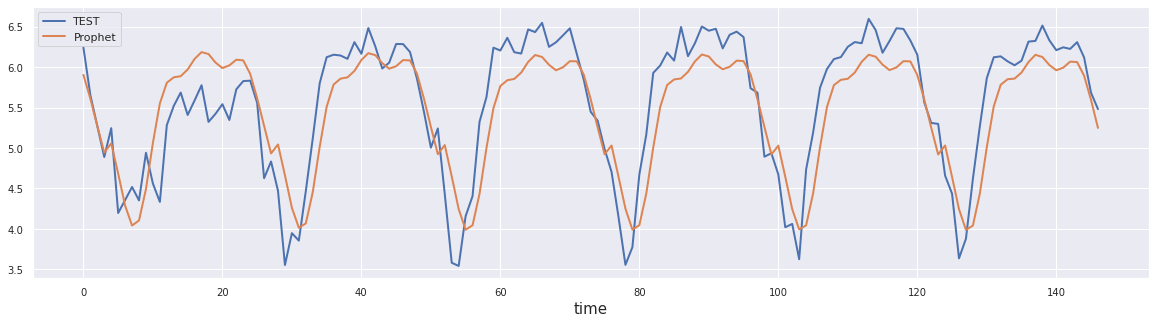

In [36]:
RollBack[['TEST', 'Prophet']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

# Modelo LSTM

In [39]:
data_LSTM = pd.DataFrame({'Log_Chamartín_Centro': df2_Final.Log_Chamartín_Centro})
data_LSTM.head()

,Log_Chamartín_Centro
ds,
2020-06-01 00:00:00,4.345453
2020-06-01 01:00:00,3.478621
2020-06-01 02:00:00,3.005138
2020-06-01 03:00:00,3.836890
2020-06-01 04:00:00,4.159836


In [40]:
Y = data_LSTM
size = int(len(Y) * 0.9)

train_Y, test_Y = Y[0:size], Y[size:len(Y)]

In [41]:
scaler = MinMaxScaler()
scaler.fit(train_Y)
scaled_train_data = scaler.transform(train_Y)
scaled_test_data = scaler.transform(test_Y)

In [42]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [43]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, input_shape=(n_input, n_features)))
#lstm_model.add(LSTM(units=50, return_sequences = True))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

2022-08-25 17:17:35.999421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 17:17:35.999499: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 17:17:35.999552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Budgie77): /proc/driver/nvidia/version does not exist
2022-08-25 17:17:36.030531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


## Entrenamos el modelo

In [44]:
lstm_model.fit_generator(generator,epochs=20)

/tmp/ipykernel_4887/544290934.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  lstm_model.fit_generator(generator,epochs=20)


Epoch 1/20
1305/1305 [==============================] - 17s 10ms/step - loss: 0.0146
Epoch 2/20
1305/1305 [==============================] - 14s 11ms/step - loss: 0.0060
Epoch 3/20
1305/1305 [==============================] - 14s 11ms/step - loss: 0.0054
Epoch 4/20
1305/1305 [==============================] - 15s 11ms/step - loss: 0.0053
Epoch 5/20
1305/1305 [==============================] - 16s 12ms/step - loss: 0.0052
Epoch 6/20
1305/1305 [==============================] - 15s 12ms/step - loss: 0.0046
Epoch 7/20
1305/1305 [==============================] - 14s 10ms/step - loss: 0.0045
Epoch 8/20
1305/1305 [==============================] - 17s 13ms/step - loss: 0.0044
Epoch 9/20
1305/1305 [==============================] - 13s 10ms/step - loss: 0.0043
Epoch 10/20
1305/1305 [==============================] - 14s 11ms/step - loss: 0.0043
Epoch 11/20
1305/1305 [==============================] - 15s 11ms/step - loss: 0.0041
Epoch 12/20
1305/1305 [==============================] - 14s 11

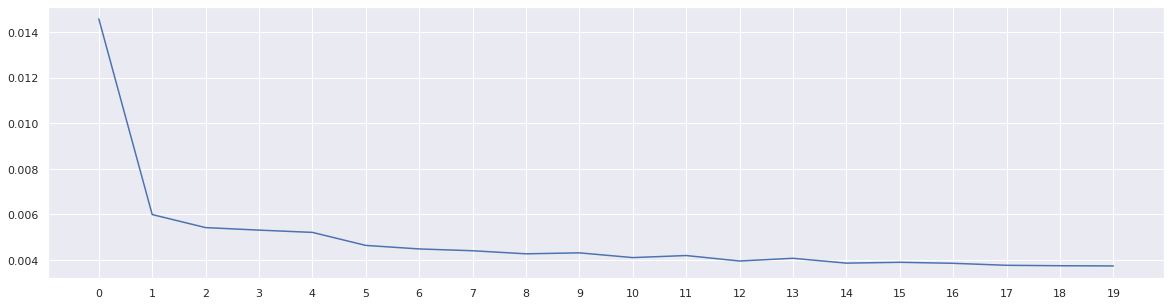

In [45]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [46]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [47]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [48]:
error_LSTM = mean_squared_error(test, lstm_predictions) ** 0.5
print('Test RMSE: %.3f' % error_LSTM)

Test RMSE: 0.985


In [49]:
RollBack = pd.concat([RollBack,pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})],axis=1)
RollBack.head()

,TEST,Prophet,LSTM
0,6.242900,5.905246,5.870109
1,5.653145,5.609968,5.691101
2,5.271244,5.272568,5.483817
3,4.889364,4.943629,5.303130
4,5.246166,5.057237,5.070215


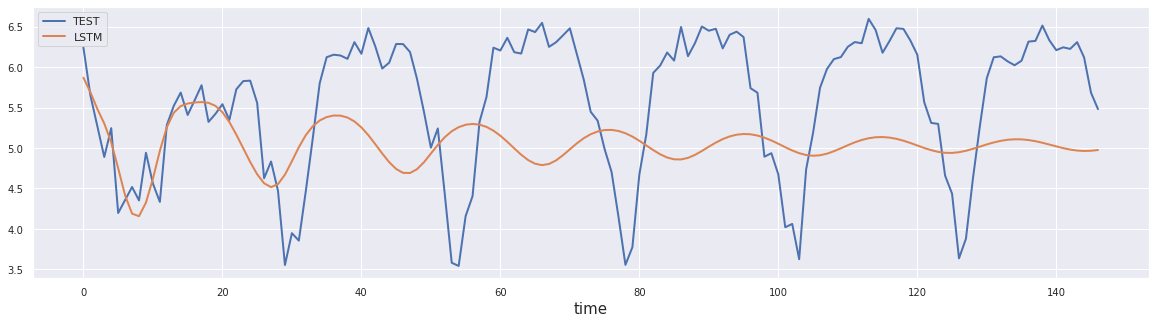

In [50]:
RollBack[['TEST', 'LSTM']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

In [51]:
#print('Test RMSE ARIMA: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.ARIMA)))
#print('Test RMSE SARIMA: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.SARIMA)))
print('Test RMSE Prophet: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.Prophet)))
print('Test RMSE LSTM: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.LSTM)))

Test RMSE Prophet: 15826.645
Test RMSE LSTM: 73802.116


# Modelo ARIMA

In [38]:
X = df2_Final['Log_Chamartín-Centro'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]


def ARIMA_FUNCTION(p,q):
	for t in range(len(test)):
		model_1 = ARIMA(history, order=(p,1,q))
		model_fit_1 = model_1.fit(disp=0)
		output = model_fit_1.forecast()
		yhat = output[0]
		predictions.append(yhat)
		obs = test[t]
		history.append(obs)
return mean_squared_error(test, predictions)**0.5

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

## Verificamos los escenarios del modelo ARIMA para ver cual presenta mejores resultados

In [ ]:
results=[]
for i in range(3):
    for j in range(4):
        if (i>j or i==0) and (i-j<3) :
            predictions = list()
            history = [x for x in train]
            results.append([i,j,ARIMA_FUNCTION(i,j)])
            #print((i,j))
#results